In [23]:
# Simulates basic flip-flop circuits in Python using a functional approach.
# Implements SR Latch and D Flip-Flop using basic logic gate functions (NOT, AND, OR, NOR).
# All inputs are assumed to be 0 or 1 (treated as boolean).
# State is managed using a dictionary instead of class instances.

# Basic gate functions
def not_gate(a):
    return 1 if a == 0 else 0

def and_gate(a, b):
    return 1 if a == 1 and b == 1 else 0

def or_gate(a, b):
    return 1 if a == 1 or b == 1 else 0

def nor_gate(a, b):
    return 1 if a == 0 and b == 0 else 0

# SR Latch: Basic memory element using NOR gates
def sr_latch(S, R, state):
    Q = state.get('Q', 0)
    Q_bar = state.get('Q_bar', 1)
    next_Q = nor_gate(R, Q_bar)
    next_Q_bar = nor_gate(S, next_Q)
    state['Q'] = next_Q
    state['Q_bar'] = next_Q_bar
    return next_Q, next_Q_bar, state

# D Flip-Flop: Edge-triggered memory element
def d_flip_flop(D, clock, state):
    # state is a dictionary with 'Q', 'Q_bar', and 'prev_clock' keys
    prev_clock = state.get('prev_clock', 0)  # Track previous clock for edge detection
    Q = state.get('Q', 0)  # Default initial Q = 0
    Q_bar = state.get('Q_bar', 1)  # Default initial Q_bar = 1
    
    # Detect rising edge (clock transitions from 0 to 1)
    clock_edge = and_gate(clock, not_gate(prev_clock))
    
    # Generate S and R for SR Latch
    S = and_gate(D, clock_edge)
    R = and_gate(not_gate(D), clock_edge)
    
    # Update SR Latch
    next_Q, next_Q_bar, latch_state = sr_latch(S, R, {'Q': Q, 'Q_bar': Q_bar})
    
    # Update state with new values and current clock
    state['Q'] = next_Q
    state['Q_bar'] = next_Q_bar
    state['prev_clock'] = clock
    
    return next_Q, next_Q_bar, state

# Example usage
if __name__ == "__main__":
    # Initialize state dictionaries
    sr_state = {'Q': 0, 'Q_bar': 1}
    dff_state = {'Q': 0, 'Q_bar': 1, 'prev_clock': 0}
    
    # Test SR Latch
    print("SR Latch: S=0, R=0 -> Q, Q_bar =", sr_latch(0, 0, sr_state)[:2])  # Hold state
    print("SR Latch: S=1, R=0 -> Q, Q_bar =", sr_latch(1, 0, sr_state)[:2])  # Set (Q=1)
    print("SR Latch: S=0, R=1 -> Q, Q_bar =", sr_latch(0, 1, sr_state)[:2])  # Reset (Q=0)
    print("SR Latch: S=0, R=0 -> Q, Q_bar =", sr_latch(0, 0, sr_state)[:2])  # Hold state
    
    # Test D Flip-Flop
    print("\nD Flip-Flop: D=1, Clock=0 -> Q, Q_bar =", d_flip_flop(1, 0, dff_state)[:2])  # No change
    print("D Flip-Flop: D=1, Clock=1 -> Q, Q_bar =", d_flip_flop(1, 1, dff_state)[:2])  # Rising edge, Q=1
    print("D Flip-Flop: D=0, Clock=0 -> Q, Q_bar =", d_flip_flop(0, 0, dff_state)[:2])  # No change
    print("D Flip-Flop: D=0, Clock=1 -> Q, Q_bar =", d_flip_flop(0, 1, dff_state)[:2])  # Rising edge, Q=0

SR Latch: S=0, R=0 -> Q, Q_bar = (0, 1)
SR Latch: S=1, R=0 -> Q, Q_bar = (0, 0)
SR Latch: S=0, R=1 -> Q, Q_bar = (0, 1)
SR Latch: S=0, R=0 -> Q, Q_bar = (0, 1)

D Flip-Flop: D=1, Clock=0 -> Q, Q_bar = (0, 1)
D Flip-Flop: D=1, Clock=1 -> Q, Q_bar = (0, 0)
D Flip-Flop: D=0, Clock=0 -> Q, Q_bar = (1, 0)
D Flip-Flop: D=0, Clock=1 -> Q, Q_bar = (0, 1)


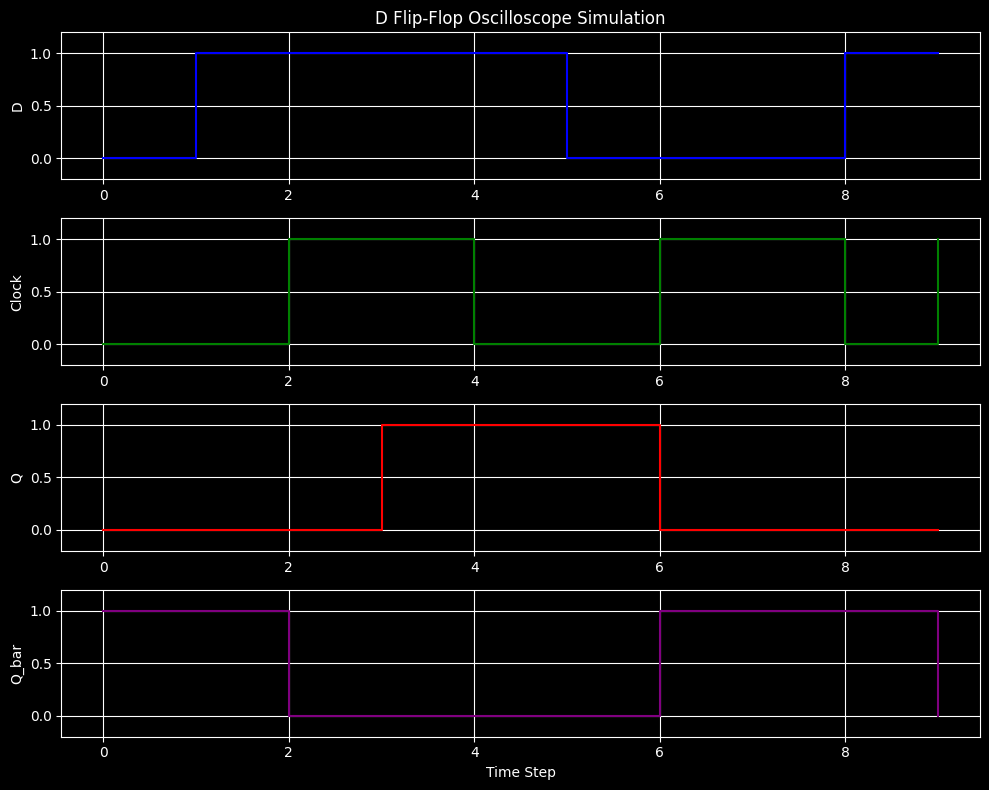

In [24]:
# Simulates a D Flip-Flop circuit and visualizes its signals like an oscilloscope using matplotlib.
# Implements basic logic gates and D Flip-Flop functionally.
# All inputs are assumed to be 0 or 1 (treated as boolean).

import matplotlib.pyplot as plt
import numpy as np

# Basic gate functions
def not_gate(a):
    return 1 if a == 0 else 0

def and_gate(a, b):
    return 1 if a == 1 and b == 1 else 0

def or_gate(a, b):
    return 1 if a == 1 or b == 1 else 0

def nor_gate(a, b):
    return 1 if a == 0 and b == 0 else 0

# SR Latch: Basic memory element using NOR gates
def sr_latch(S, R, state):
    Q = state.get('Q', 0)  # Default initial Q = 0
    Q_bar = state.get('Q_bar', 1)  # Default initial Q_bar = 1
    next_Q = nor_gate(R, Q_bar)
    next_Q_bar = nor_gate(S, next_Q)
    state['Q'] = next_Q
    state['Q_bar'] = next_Q_bar
    return next_Q, next_Q_bar, state

# D Flip-Flop: Edge-triggered memory element
def d_flip_flop(D, clock, state):
    prev_clock = state.get('prev_clock', 0)
    Q = state.get('Q', 0)
    Q_bar = state.get('Q_bar', 1)
    clock_edge = and_gate(clock, not_gate(prev_clock))
    S = and_gate(D, clock_edge)
    R = and_gate(not_gate(D), clock_edge)
    next_Q, next_Q_bar, latch_state = sr_latch(S, R, {'Q': Q, 'Q_bar': Q_bar})
    state['Q'] = next_Q
    state['Q_bar'] = next_Q_bar
    state['prev_clock'] = clock
    return next_Q, next_Q_bar, state

# Simulate D Flip-Flop over time with a sequence of inputs
def simulate_d_flip_flop(inputs):
    state = {'Q': 0, 'Q_bar': 1, 'prev_clock': 0}
    time_steps = []
    D_values = []
    clock_values = []
    Q_values = []
    Q_bar_values = []
    
    for t, (D, clock) in enumerate(inputs):
        Q, Q_bar, state = d_flip_flop(D, clock, state)
        time_steps.append(t)
        D_values.append(D)
        clock_values.append(clock)
        Q_values.append(Q)
        Q_bar_values.append(Q_bar)
    
    return time_steps, D_values, clock_values, Q_values, Q_bar_values

# Visualize signals like an oscilloscope
def plot_oscilloscope(time_steps, D_values, clock_values, Q_values, Q_bar_values):
    plt.figure(figsize=(10, 8))
    
    # Plot D signal
    plt.subplot(4, 1, 1)
    plt.step(time_steps, D_values, where='post', color='blue')
    plt.title('D Flip-Flop Oscilloscope Simulation')
    plt.ylabel('D')
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    
    # Plot Clock signal
    plt.subplot(4, 1, 2)
    plt.step(time_steps, clock_values, where='post', color='green')
    plt.ylabel('Clock')
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    
    # Plot Q signal
    plt.subplot(4, 1, 3)
    plt.step(time_steps, Q_values, where='post', color='red')
    plt.ylabel('Q')
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    
    # Plot Q_bar signal
    plt.subplot(4, 1, 4)
    plt.step(time_steps, Q_bar_values, where='post', color='purple')
    plt.ylabel('Q_bar')
    plt.xlabel('Time Step')
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Define input sequence: (D, Clock) pairs
    inputs = [
        (0, 0),  # t=0
        (1, 0),  # t=1
        (1, 1),  # t=2 (rising edge, Q should become 1)
        (1, 1),  # t=3
        (1, 0),  # t=4
        (0, 0),  # t=5
        (0, 1),  # t=6 (rising edge, Q should become 0)
        (0, 1),  # t=7
        (1, 0),  # t=8
        (1, 1),  # t=9 (rising edge, Q should become 1)
    ]
    
    # Simulate and visualize
    time_steps, D_values, clock_values, Q_values, Q_bar_values = simulate_d_flip_flop(inputs)
    plot_oscilloscope(time_steps, D_values, clock_values, Q_values, Q_bar_values)

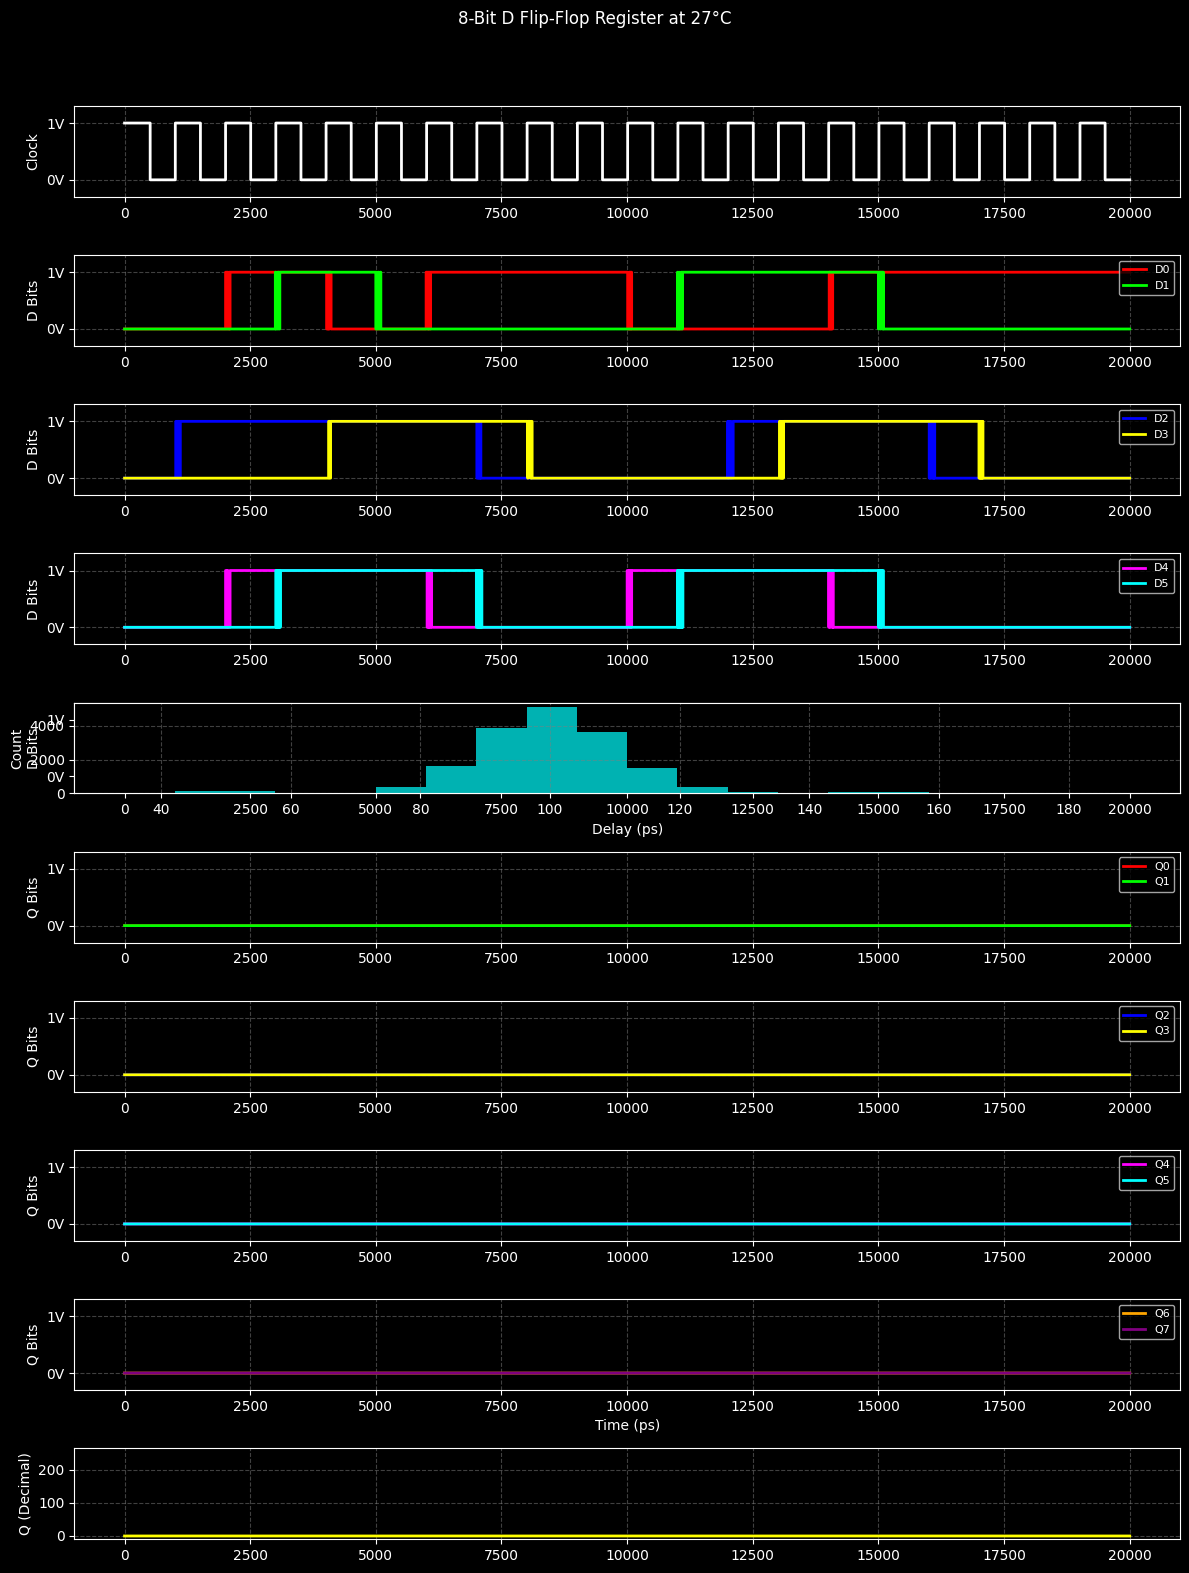

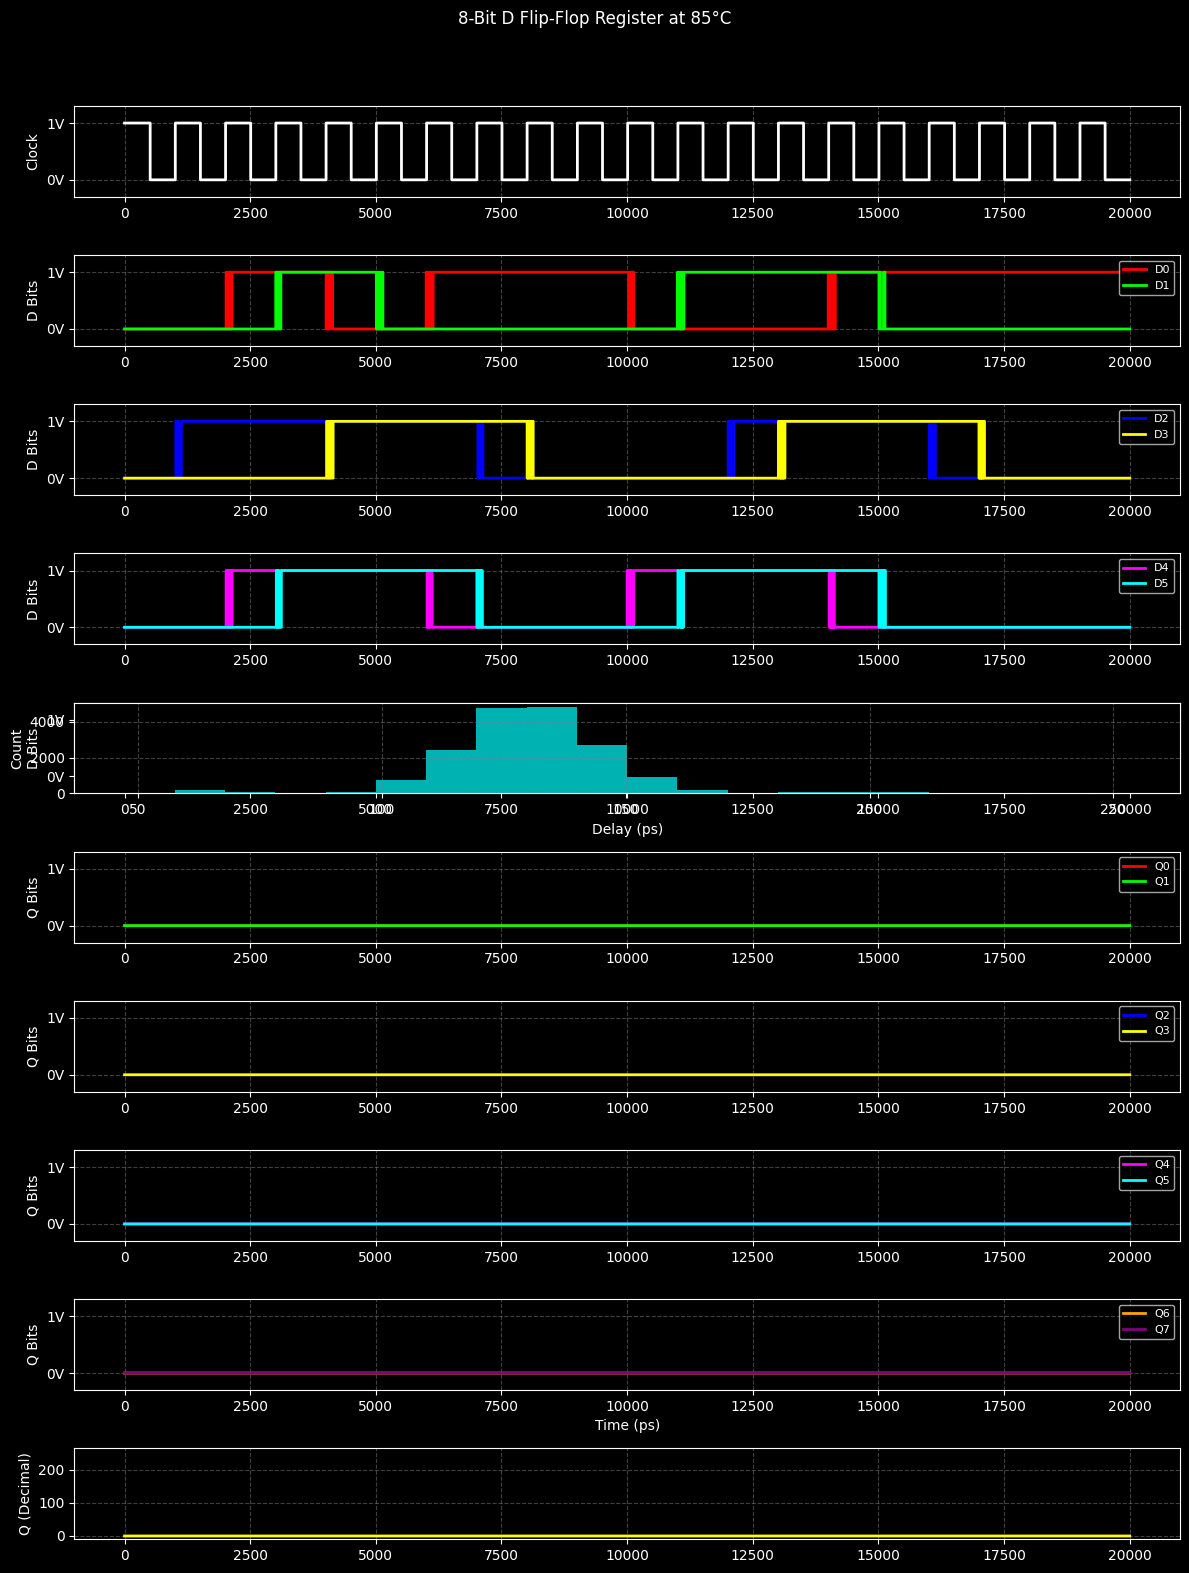

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from scipy.interpolate import interp1d

# Parameters (65nm CMOS based)
THRESHOLD = 0.5
DELAY_NOT = 50e-12  # NOT gate delay (50 ps)
DELAY_AND_OR = 100e-12  # AND/OR gate delay (100 ps)
DELAY_NOR = 150e-12  # NOR gate delay (150 ps)
JITTER_STD = 0.1  # ±10% jitter (Gaussian)
T_0 = 300  # Reference temperature (27°C in Kelvin)
V_DD = 1.2  # Supply voltage (V)
V_TH = 0.4  # Threshold voltage (V)
C_L = 10e-15  # Load capacitance (10 fF)
I_DS = 200e-6  # Drain-source current (200 uA)
STEP_SIZE = 10e-12  # Time step (10 ps)
CLOCK_PERIOD = 1000e-12  # Clock period (1000 ps, 1 MHz)

# Temperature effect on delay
def temperature_scaling(temperature_kelvin):
    # Mobility: mu(T) = mu_0 * (T_0 / T)^1.5
    return (temperature_kelvin / T_0) ** 1.5

# Apply jitter to delay (Gaussian)
def apply_jitter(base_delay):
    jitter = np.random.normal(0, JITTER_STD)
    return max(0, base_delay * (1 + jitter))

# Discrete gate functions with jitter and temperature
def not_gate(a, delay_queue, temperature_kelvin, time, jitter_log):
    result = 1 if a < THRESHOLD else 0
    delay = apply_jitter(DELAY_NOT) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)  # Log in ps
    delay_queue.append((time + delay, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def and_gate(a, b, delay_queue, temperature_kelvin, time, jitter_log):
    result = 1 if a >= THRESHOLD and b >= THRESHOLD else 0
    delay = apply_jitter(DELAY_AND_OR) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)
    delay_queue.append((time + delay, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def or_gate(a, b, delay_queue, temperature_kelvin, time, jitter_log):
    result = 1 if a >= THRESHOLD or b >= THRESHOLD else 0
    delay = apply_jitter(DELAY_AND_OR) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)
    delay_queue.append((time + delay, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def nor_gate(a, b, delay_queue, temperature_kelvin, time, jitter_log):
    result = not_gate(or_gate(a, b, delay_queue['or'], temperature_kelvin, time, jitter_log), 
                     delay_queue['not'], temperature_kelvin, time, jitter_log)
    delay = apply_jitter(DELAY_NOR) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)
    delay_queue['nor'].append((time + delay, result))
    while delay_queue['nor'] and delay_queue['nor'][0][0] <= time:
        return delay_queue['nor'].popleft()[1]
    return delay_queue['nor'][0][1] if delay_queue['nor'] else result

# Digital SR Latch
def sr_latch_update(S, R, Q, Q_bar, delay_queues, temperature_kelvin, time, jitter_log):
    if S >= THRESHOLD and R >= THRESHOLD:
        return Q, Q_bar
    elif S >= THRESHOLD:
        next_Q, next_Q_bar = 1, 0
    elif R >= THRESHOLD:
        next_Q, next_Q_bar = 0, 1
    else:
        next_Q, next_Q_bar = Q, Q_bar

    delay = apply_jitter(DELAY_NOR) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)
    delay_queues['Q'].append((time + delay, next_Q))
    delay_queues['Q_bar'].append((time + delay, next_Q_bar))
    
    delayed_Q = next_Q
    delayed_Q_bar = next_Q_bar
    while delay_queues['Q'] and delay_queues['Q'][0][0] <= time:
        delayed_Q = delay_queues['Q'].popleft()[1]
    while delay_queues['Q_bar'] and delay_queues['Q_bar'][0][0] <= time:
        delayed_Q_bar = delay_queues['Q_bar'].popleft()[1]
    
    return delayed_Q, delayed_Q_bar

# 8-bit D Flip-Flop
def d_flip_flop_8bit_update(D_bits, clock, states, delay_queues, temperature_kelvin, time, jitter_log):
    Q_bits = []
    Q_bar_bits = []
    for i in range(8):
        Qm = states[i].get('Qm', 0)
        Qm_bar = states[i].get('Qm_bar', 1)
        Q = states[i].get('Q', 0)
        Q_bar = states[i].get('Q_bar', 1)
        prev_clock = states[i].get('prev_clock', 0)

        rising_edge = clock >= THRESHOLD and prev_clock < THRESHOLD

        if rising_edge:
            Sm = and_gate(D_bits[i], 1, delay_queues[i]['master']['and1'], temperature_kelvin, time, jitter_log)
            Rm = and_gate(not_gate(D_bits[i], delay_queues[i]['master']['not'], temperature_kelvin, time, jitter_log), 
                          1, delay_queues[i]['master']['and2'], temperature_kelvin, time, jitter_log)
            Qm, Qm_bar = sr_latch_update(Sm, Rm, Qm, Qm_bar, delay_queues[i]['master']['latch'], 
                                         temperature_kelvin, time, jitter_log)

            Ss = and_gate(Qm, 1, delay_queues[i]['slave']['and1'], temperature_kelvin, time, jitter_log)
            Rs = and_gate(not_gate(Qm, delay_queues[i]['slave']['not'], temperature_kelvin, time, jitter_log), 
                          1, delay_queues[i]['slave']['and2'], temperature_kelvin, time, jitter_log)
            Q, Q_bar = sr_latch_update(Ss, Rs, Q, Q_bar, delay_queues[i]['slave']['latch'], 
                                       temperature_kelvin, time, jitter_log)

        states[i]['Qm'] = Qm
        states[i]['Qm_bar'] = Qm_bar
        states[i]['Q'] = Q
        states[i]['Q_bar'] = Q_bar
        states[i]['prev_clock'] = clock
        Q_bits.append(Q)
        Q_bar_bits.append(Q_bar)
    
    return Q_bits, Q_bar_bits, states

# Simulate 8-bit D Flip-Flop
def simulate_d_flip_flop_8bit(D_inputs, total_time=20000e-12, noise_level=0.05, temperature_celsius=27, clock_period=CLOCK_PERIOD):
    temperature_kelvin = temperature_celsius + 273
    time_steps = np.arange(0, total_time, STEP_SIZE)
    states = [{'Qm': 0, 'Qm_bar': 1, 'Q': 0, 'Q_bar': 1, 'prev_clock': 0} for _ in range(8)]
    jitter_log = []
    
    # Initialize delay queues for 8 bits
    max_delay = int(round(max(DELAY_NOT, DELAY_AND_OR, DELAY_NOR) * 
                          temperature_scaling(temperature_kelvin) / STEP_SIZE)) + 1
    delay_queues = [{
        'D': deque([(0, 0)] * max_delay),
        'master': {
            'and1': deque([(0, 0)] * max_delay),
            'and2': deque([(0, 0)] * max_delay),
            'not': deque([(0, 0)] * max_delay),
            'or': deque([(0, 0)] * max_delay),
            'nor': deque([(0, 0)] * max_delay),
            'latch': {'Q': deque([(0, 0)] * max_delay), 'Q_bar': deque([(0, 1)] * max_delay)}
        },
        'slave': {
            'and1': deque([(0, 0)] * max_delay),
            'and2': deque([(0, 0)] * max_delay),
            'not': deque([(0, 0)] * max_delay),
            'or': deque([(0, 0)] * max_delay),
            'nor': deque([(0, 0)] * max_delay),
            'latch': {'Q': deque([(0, 0)] * max_delay), 'Q_bar': deque([(0, 1)] * max_delay)}
        }
    } for _ in range(8)]
    
    # Interpolate D inputs for each bit
    D_interps = []
    for bit_inputs in D_inputs:
        times, values = zip(*bit_inputs)
        interp = interp1d(times, values, kind='previous', fill_value=values[-1], bounds_error=False)
        D_interps.append(interp)
    
    # Initialize output arrays
    D_values = [[] for _ in range(8)]
    clock_values = []
    Q_values = [[] for _ in range(8)]
    
    for t in time_steps:
        # Generate clock (square wave, 50% duty cycle)
        clock = 1 if (t % clock_period) < (clock_period / 2) else 0
        clock = np.clip(clock + np.random.normal(0, noise_level), 0, 1)
        clock = 1 if clock >= THRESHOLD else 0
        
        # Get D inputs for each bit
        D_bits = [np.clip(interp(t) + np.random.normal(0, noise_level), 0, 1) for interp in D_interps]
        D_bits = [1 if d >= THRESHOLD else 0 for d in D_bits]
        
        # Update delay queues for D inputs
        for i in range(8):
            delay = apply_jitter(DELAY_AND_OR) * temperature_scaling(temperature_kelvin)
            jitter_log.append(delay * 1e12)
            delay_queues[i]['D'].append((t + delay, D_bits[i]))
            while delay_queues[i]['D'] and delay_queues[i]['D'][0][0] <= t:
                D_bits[i] = delay_queues[i]['D'].popleft()[1]
        
        # Update 8-bit flip-flop
        Q_bits, Q_bar_bits, states = d_flip_flop_8bit_update(D_bits, clock, states, delay_queues, 
                                                             temperature_kelvin, t, jitter_log)
        
        # Store values
        for i in range(8):
            D_values[i].append(D_bits[i])
            Q_values[i].append(Q_bits[i])
        clock_values.append(clock)
    
    return time_steps, D_values, clock_values, Q_values, jitter_log

# Visualize 8-bit signals and jitter
def plot_oscilloscope(time_steps, D_values, clock_values, Q_values, jitter_log, temperature_celsius):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 16))
    
    # Colors for each bit
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#800080']
    
    # Clock plot
    ax_clock = fig.add_subplot(10, 1, 1)
    ax_clock.step(time_steps * 1e12, clock_values, where='post', color='white', linewidth=2)
    ax_clock.set_ylabel('Clock', color='white', fontsize=10)
    ax_clock.set_ylim(-0.3, 1.3)
    ax_clock.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_clock.set_yticks([0, 1])
    ax_clock.set_yticklabels(['0V', '1V'], color='white')
    
    # D and Q plots for 8 bits
    axes_D = [fig.add_subplot(10, 1, i+2) for i in range(4)]
    axes_Q = [fig.add_subplot(10, 1, i+6) for i in range(4)]
    
    for i in range(8):
        ax_D = axes_D[i // 2]
        ax_Q = axes_Q[i // 2]
        ax_D.step(time_steps * 1e12, D_values[i], where='post', color=colors[i], linewidth=2, label=f'D{i}')
        ax_Q.step(time_steps * 1e12, Q_values[i], where='post', color=colors[i], linewidth=2, label=f'Q{i}')
    
    for ax in axes_D + axes_Q:
        ax.set_ylim(-0.3, 1.3)
        ax.grid(True, color='gray', linestyle='--', alpha=0.5)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0V', '1V'], color='white')
        ax.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    for ax in axes_D:
        ax.set_ylabel('D Bits', color='white', fontsize=10)
    for ax in axes_Q:
        ax.set_ylabel('Q Bits', color='white', fontsize=10)
    
    axes_Q[-1].set_xlabel('Time (ps)', color='white', fontsize=10)
    
    # Compute 8-bit value with transition markers
    Q_decimal = [sum(Q_values[i][j] * (2**i) for i in range(8)) for j in range(len(time_steps))]
    ax_decimal = fig.add_subplot(10, 1, 10)
    ax_decimal.step(time_steps * 1e12, Q_decimal, where='post', color='yellow', linewidth=2)
    
    # Add markers for transitions
    transitions = np.where(np.diff(Q_decimal) != 0)[0] + 1
    for idx in transitions:
        ax_decimal.plot(time_steps[idx] * 1e12, Q_decimal[idx], 'ro', markersize=5)
    
    ax_decimal.set_ylabel('Q (Decimal)', color='white', fontsize=10)
    ax_decimal.set_ylim(-10, 265)
    ax_decimal.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_decimal.tick_params(axis='y', colors='white')
    
    # Jitter histogram
    ax_jitter = fig.add_subplot(10, 1, 5)
    ax_jitter.hist(jitter_log, bins=20, color='cyan', alpha=0.7)
    ax_jitter.set_xlabel('Delay (ps)', color='white', fontsize=10)
    ax_jitter.set_ylabel('Count', color='white', fontsize=10)
    ax_jitter.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_jitter.tick_params(axis='x', colors='white')
    ax_jitter.tick_params(axis='y', colors='white')
    
    fig.suptitle(f'8-Bit D Flip-Flop Register at {temperature_celsius}°C', color='white', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
if __name__ == "__main__":
    # User-defined D inputs: [(time in ps, value), ...] for each bit
    D_inputs = [
        [(0, 0), (2000e-12, 1), (4000e-12, 0), (6000e-12, 1), (10000e-12, 0), (14000e-12, 1)],  # Bit 0
        [(0, 0), (3000e-12, 1), (5000e-12, 0), (11000e-12, 1), (15000e-12, 0)],              # Bit 1
        [(0, 0), (1000e-12, 1), (7000e-12, 0), (12000e-12, 1), (16000e-12, 0)],              # Bit 2
        [(0, 0), (4000e-12, 1), (8000e-12, 0), (13000e-12, 1), (17000e-12, 0)],              # Bit 3
        [(0, 0), (2000e-12, 1), (6000e-12, 0), (10000e-12, 1), (14000e-12, 0)],              # Bit 4
        [(0, 0), (3000e-12, 1), (7000e-12, 0), (11000e-12, 1), (15000e-12, 0)],              # Bit 5
        [(0, 0), (1000e-12, 1), (8000e-12, 0), (12000e-12, 1), (16000e-12, 0)],              # Bit 6
        [(0, 0), (4000e-12, 1), (9000e-12, 0), (13000e-12, 1), (17000e-12, 0)]               # Bit 7
    ]
    
    # Simulate at 27°C and 85°C
    for temp in [27, 85]:
        time_steps, D_values, clock_values, Q_values, jitter_log = simulate_d_flip_flop_8bit(
            D_inputs, total_time=20000e-12, noise_level=0.05, temperature_celsius=temp)
        plot_oscilloscope(time_steps, D_values, clock_values, Q_values, jitter_log, temp)

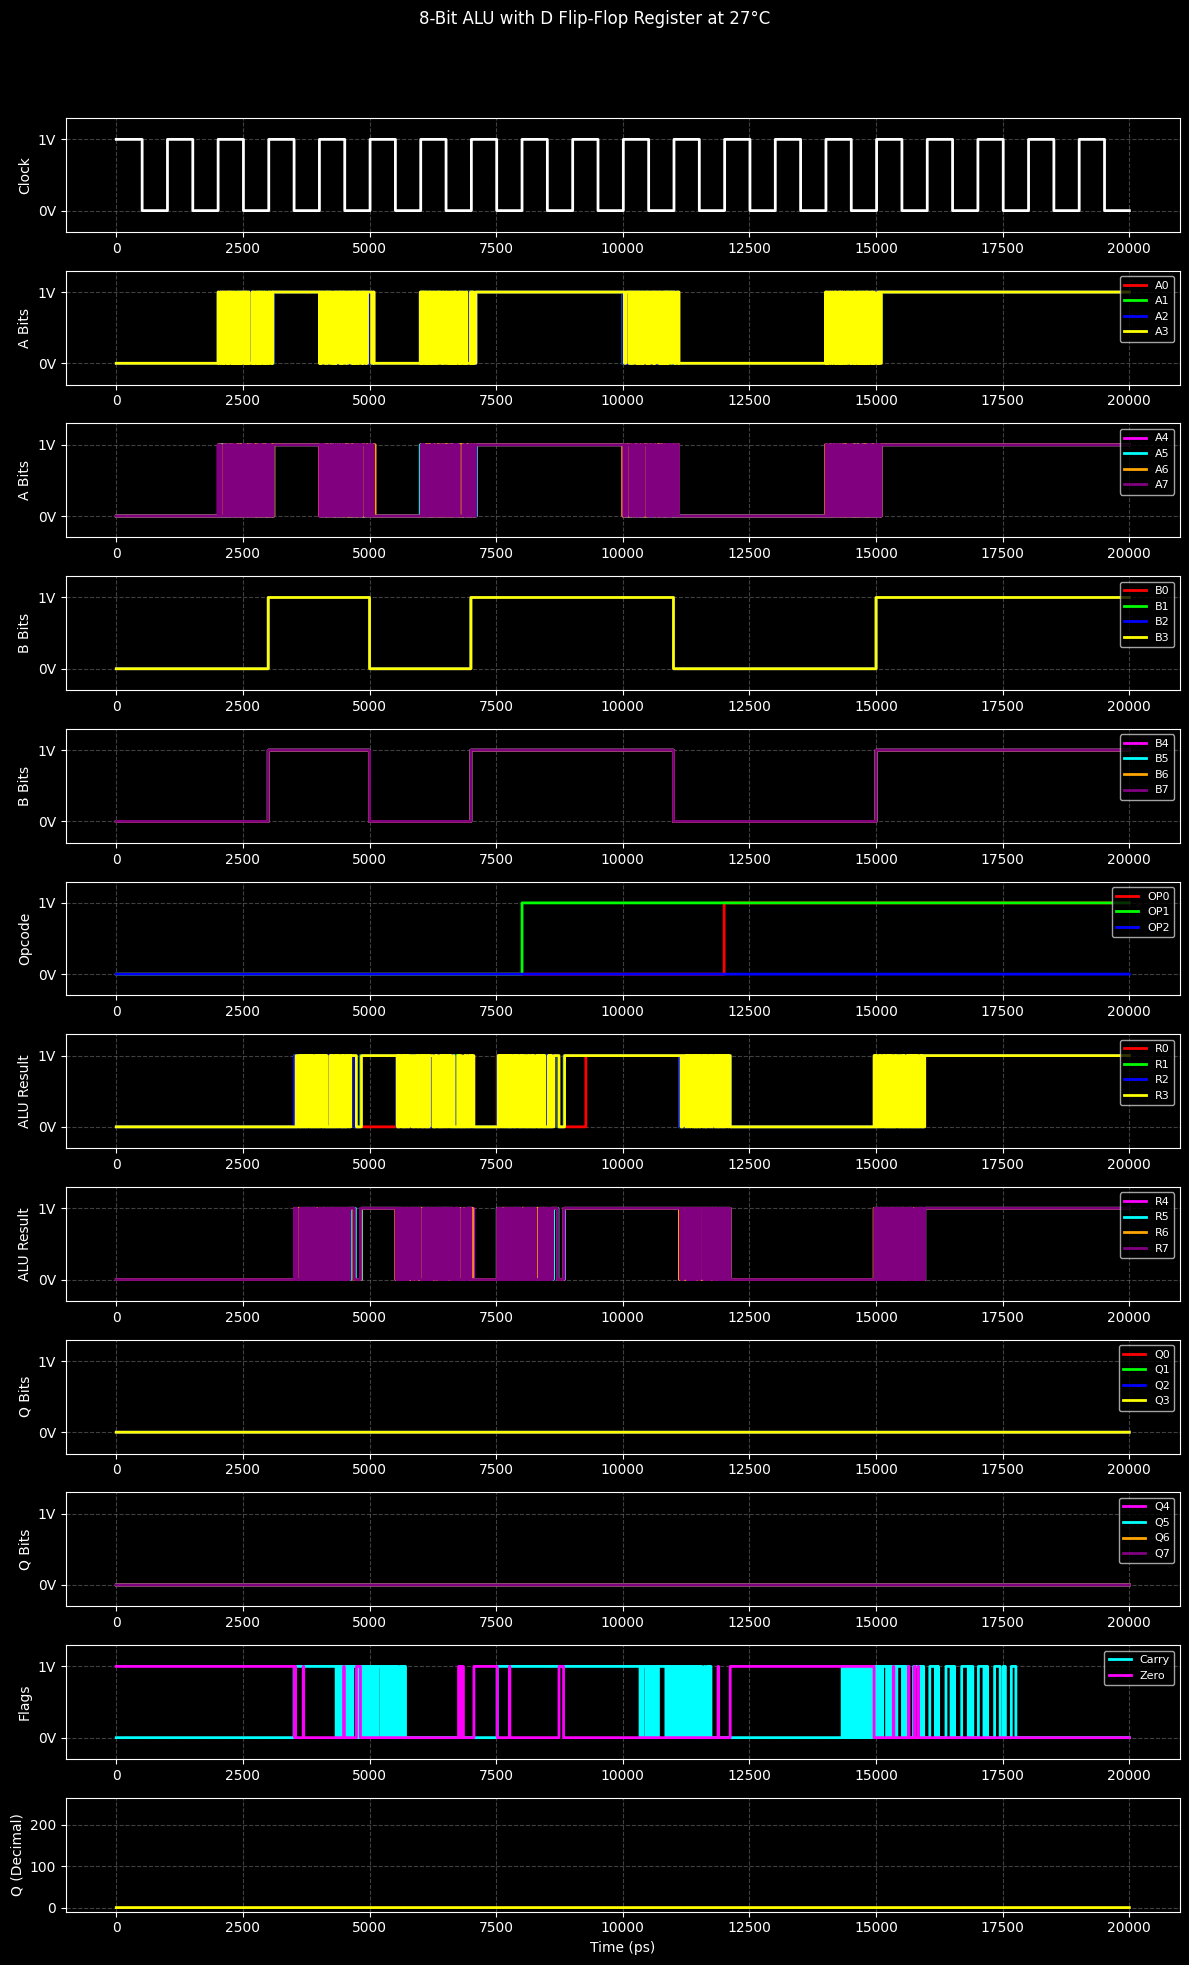

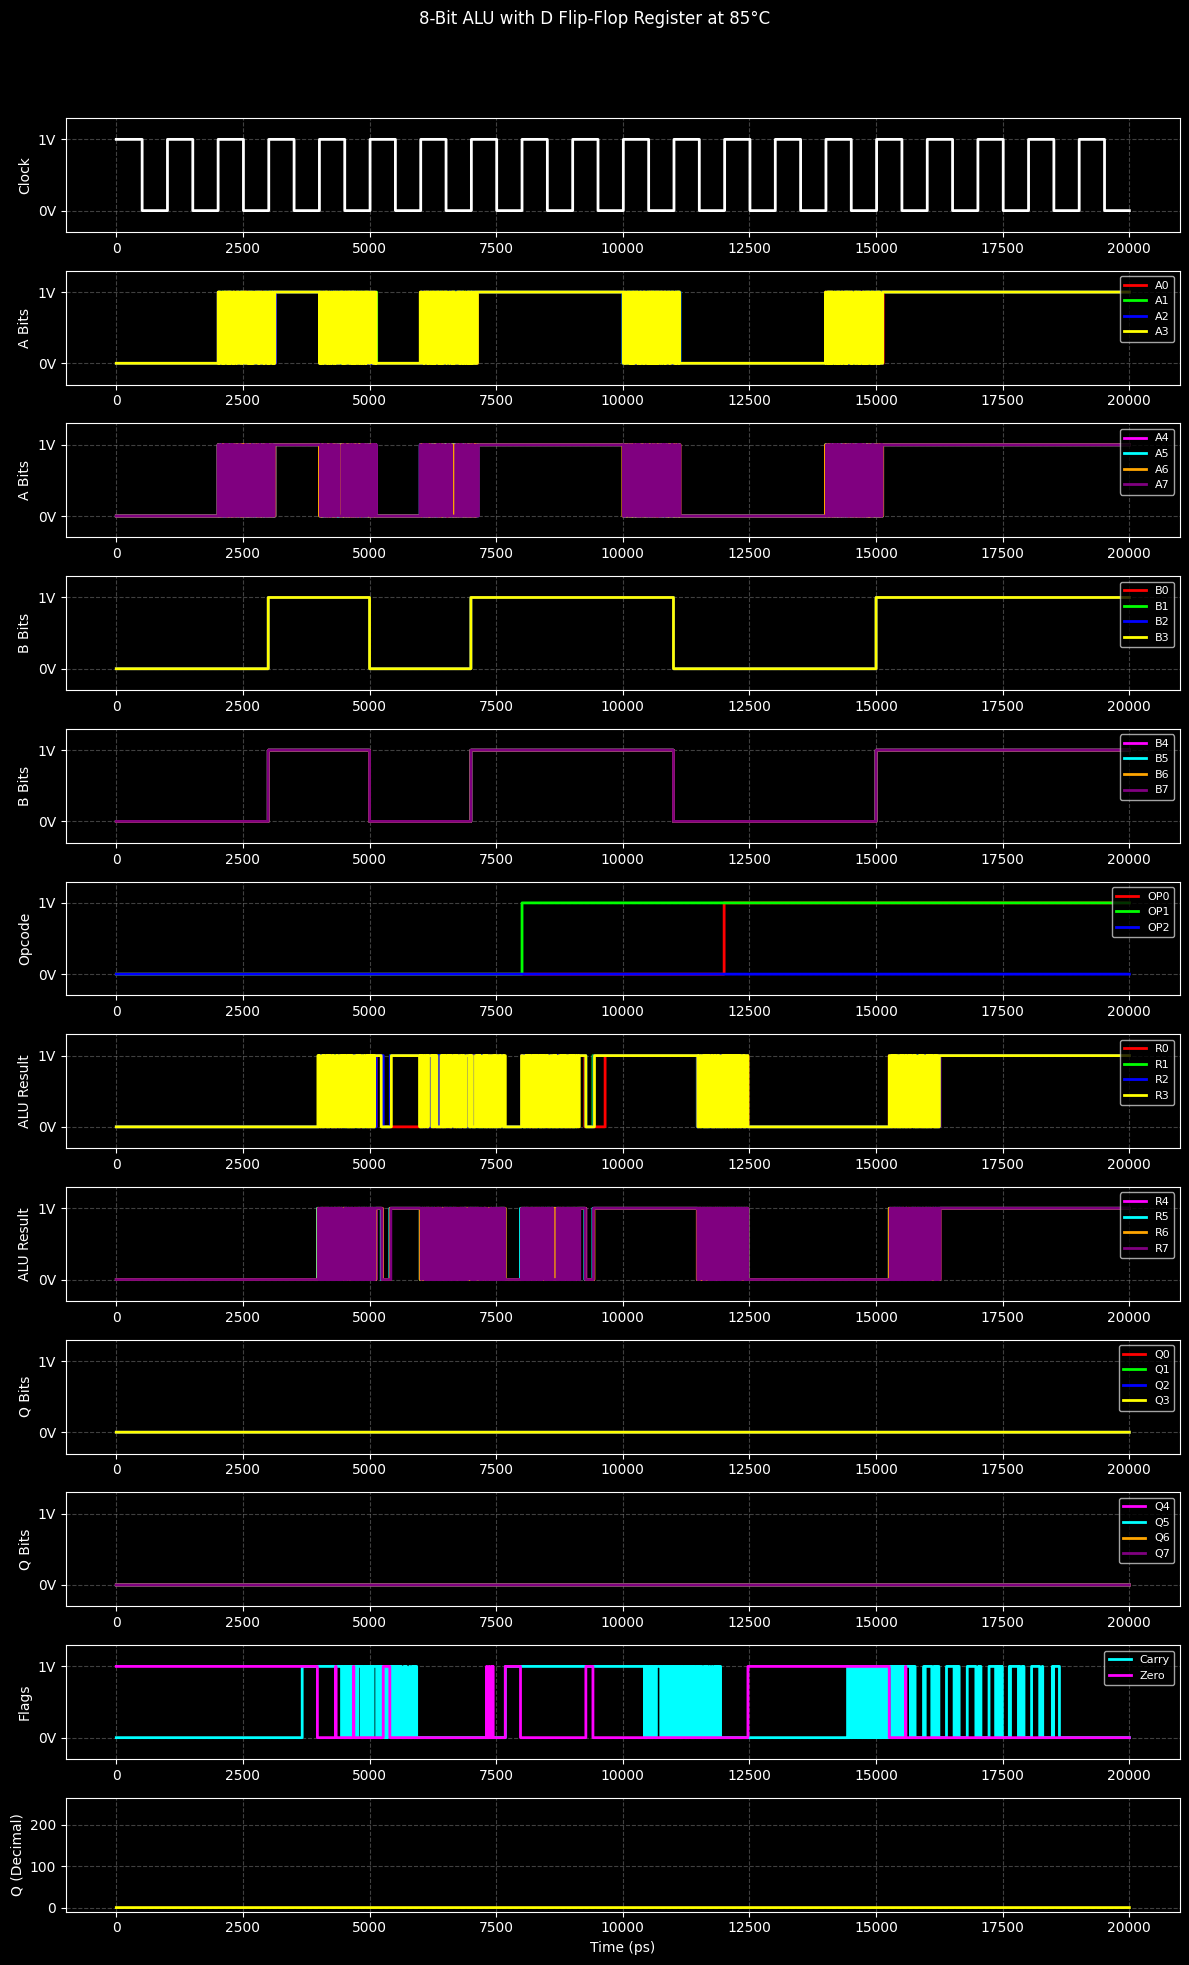

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from scipy.interpolate import interp1d

# Parameters (65nm CMOS based)
THRESHOLD = 0.5
DELAY_NOT = 50e-12  # NOT gate delay (50 ps)
DELAY_AND_OR = 100e-12  # AND/OR gate delay (100 ps)
DELAY_NOR = 150e-12  # NOR gate delay (150 ps)
DELAY_XOR = 150e-12  # XOR gate delay (150 ps)
JITTER_STD = 0.1  # ±10% jitter (Gaussian)
T_0 = 300  # Reference temperature (27°C in Kelvin)
V_DD = 1.2  # Supply voltage (V)
V_TH = 0.4  # Threshold voltage (V)
C_L = 10e-15  # Load capacitance (10 fF)
I_DS = 200e-6  # Drain-source current (200 uA)
STEP_SIZE = 10e-12  # Time step (10 ps)
CLOCK_PERIOD = 1000e-12  # Clock period (1000 ps, 1 MHz)

# Temperature effect on delay
def temperature_scaling(temperature_kelvin):
    return (temperature_kelvin / T_0) ** 1.5

# Apply jitter to delay (Gaussian)
def apply_jitter(base_delay):
    jitter = np.random.normal(0, JITTER_STD)
    return max(0, base_delay * (1 + jitter))

# Discrete gate functions
def not_gate(a, delay_queue, temperature_kelvin, time, jitter_log):
    result = 1 if a < THRESHOLD else 0
    delay = apply_jitter(DELAY_NOT) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)
    delay_queue.append((time + delay, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def and_gate(a, b, delay_queue, temperature_kelvin, time, jitter_log):
    result = 1 if a >= THRESHOLD and b >= THRESHOLD else 0
    delay = apply_jitter(DELAY_AND_OR) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)
    delay_queue.append((time + delay, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def or_gate(a, b, delay_queue, temperature_kelvin, time, jitter_log):
    result = 1 if a >= THRESHOLD or b >= THRESHOLD else 0
    delay = apply_jitter(DELAY_AND_OR) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)
    delay_queue.append((time + delay, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def xor_gate(a, b, delay_queue, temperature_kelvin, time, jitter_log):
    result = 1 if (a >= THRESHOLD) != (b >= THRESHOLD) else 0
    delay = apply_jitter(DELAY_XOR) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)
    delay_queue.append((time + delay, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def nor_gate(a, b, delay_queue, temperature_kelvin, time, jitter_log):
    result = not_gate(or_gate(a, b, delay_queue['or'], temperature_kelvin, time, jitter_log), 
                     delay_queue['not'], temperature_kelvin, time, jitter_log)
    delay = apply_jitter(DELAY_NOR) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)
    delay_queue['nor'].append((time + delay, result))
    while delay_queue['nor'] and delay_queue['nor'][0][0] <= time:
        return delay_queue['nor'].popleft()[1]
    return delay_queue['nor'][0][1] if delay_queue['nor'] else result

# 1-bit ALU
def alu_1bit(a, b, cin, opcode, delay_queues, temperature_kelvin, time, jitter_log):
    # Operations: 000=ADD, 001=SUB, 010=AND, 011=OR, 100=XOR, 101=SHL, 110=SHR
    op0, op1, op2 = opcode[0], opcode[1], opcode[2]
    
    # Full Adder for ADD/SUB
    b_sub = xor_gate(b, op0, delay_queues['xor_b'], temperature_kelvin, time, jitter_log)  # B XOR op0 for SUB
    sum_xor1 = xor_gate(a, b_sub, delay_queues['xor1'], temperature_kelvin, time, jitter_log)
    result_add = xor_gate(sum_xor1, cin, delay_queues['xor2'], temperature_kelvin, time, jitter_log)
    carry1 = and_gate(a, b_sub, delay_queues['and1'], temperature_kelvin, time, jitter_log)
    carry2 = and_gate(sum_xor1, cin, delay_queues['and2'], temperature_kelvin, time, jitter_log)
    cout = or_gate(carry1, carry2, delay_queues['or_carry'], temperature_kelvin, time, jitter_log)
    
    result_sub = result_add
    # Logic operations
    result_and = and_gate(a, b, delay_queues['and_logic'], temperature_kelvin, time, jitter_log)
    result_or = or_gate(a, b, delay_queues['or_logic'], temperature_kelvin, time, jitter_log)
    result_xor = xor_gate(a, b, delay_queues['xor_logic'], temperature_kelvin, time, jitter_log)
    
    # Shift operations (SHL: b<<1, SHR: b>>1, simplified for 1-bit)
    result_shl = b if op0 == 0 else cin  # SHL: use Cin as input bit
    result_shr = b if op0 == 0 else cin  # SHR: use Cin as input bit
    
    # Multiplexer to select operation
    sel_add = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], temperature_kelvin, time, jitter_log), 
                               not_gate(op1, delay_queues['mux_not1'], temperature_kelvin, time, jitter_log), 
                               delay_queues['mux_and1'], temperature_kelvin, time, jitter_log), 
                      not_gate(op0, delay_queues['mux_not0'], temperature_kelvin, time, jitter_log), 
                      delay_queues['mux_and_add'], temperature_kelvin, time, jitter_log)
    sel_sub = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], temperature_kelvin, time, jitter_log), 
                               not_gate(op1, delay_queues['mux_not1'], temperature_kelvin, time, jitter_log), 
                               delay_queues['mux_and1'], temperature_kelvin, time, jitter_log), 
                      op0, delay_queues['mux_and_sub'], temperature_kelvin, time, jitter_log)
    sel_and = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], temperature_kelvin, time, jitter_log), 
                               op1, delay_queues['mux_and2'], temperature_kelvin, time, jitter_log), 
                      not_gate(op0, delay_queues['mux_not0'], temperature_kelvin, time, jitter_log), 
                      delay_queues['mux_and_and'], temperature_kelvin, time, jitter_log)
    sel_or = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], temperature_kelvin, time, jitter_log), 
                              op1, delay_queues['mux_and2'], temperature_kelvin, time, jitter_log), 
                     op0, delay_queues['mux_and_or'], temperature_kelvin, time, jitter_log)
    sel_xor = and_gate(and_gate(op2, not_gate(op1, delay_queues['mux_not1'], temperature_kelvin, time, jitter_log), 
                               delay_queues['mux_and3'], temperature_kelvin, time, jitter_log), 
                      not_gate(op0, delay_queues['mux_not0'], temperature_kelvin, time, jitter_log), 
                      delay_queues['mux_and_xor'], temperature_kelvin, time, jitter_log)
    sel_shl = and_gate(and_gate(op2, not_gate(op1, delay_queues['mux_not1'], temperature_kelvin, time, jitter_log), 
                               delay_queues['mux_and3'], temperature_kelvin, time, jitter_log), 
                      op0, delay_queues['mux_and_shl'], temperature_kelvin, time, jitter_log)
    sel_shr = and_gate(and_gate(op2, op1, delay_queues['mux_and4'], temperature_kelvin, time, jitter_log), 
                      not_gate(op0, delay_queues['mux_not0'], temperature_kelvin, time, jitter_log), 
                      delay_queues['mux_and_shr'], temperature_kelvin, time, jitter_log)
    
    result = or_gate(or_gate(or_gate(or_gate(or_gate(or_gate(
        and_gate(result_add, sel_add, delay_queues['mux_result1'], temperature_kelvin, time, jitter_log),
        and_gate(result_sub, sel_sub, delay_queues['mux_result2'], temperature_kelvin, time, jitter_log),
        delay_queues['mux_or1'], temperature_kelvin, time, jitter_log),
        and_gate(result_and, sel_and, delay_queues['mux_result3'], temperature_kelvin, time, jitter_log),
        delay_queues['mux_or2'], temperature_kelvin, time, jitter_log),
        and_gate(result_or, sel_or, delay_queues['mux_result4'], temperature_kelvin, time, jitter_log),
        delay_queues['mux_or3'], temperature_kelvin, time, jitter_log),
        and_gate(result_xor, sel_xor, delay_queues['mux_result5'], temperature_kelvin, time, jitter_log),
        delay_queues['mux_or4'], temperature_kelvin, time, jitter_log),
        and_gate(result_shl, sel_shl, delay_queues['mux_result6'], temperature_kelvin, time, jitter_log),
        delay_queues['mux_or5'], temperature_kelvin, time, jitter_log),
        and_gate(result_shr, sel_shr, delay_queues['mux_result7'], temperature_kelvin, time, jitter_log),
        delay_queues['mux_or6'], temperature_kelvin, time, jitter_log)
    
    return result, cout

# 8-bit ALU
def alu_8bit(A, B, opcode, delay_queues, temperature_kelvin, time, jitter_log):
    result = []
    cout = 0
    for i in range(8):
        res, cout = alu_1bit(A[i], B[i], cout, opcode, delay_queues[i], temperature_kelvin, time, jitter_log)
        result.append(res)
    zero = 0 if any(res >= THRESHOLD for res in result) else 1
    return result, cout, zero

# Digital SR Latch
def sr_latch_update(S, R, Q, Q_bar, delay_queues, temperature_kelvin, time, jitter_log):
    if S >= THRESHOLD and R >= THRESHOLD:
        return Q, Q_bar
    elif S >= THRESHOLD:
        next_Q, next_Q_bar = 1, 0
    elif R >= THRESHOLD:
        next_Q, next_Q_bar = 0, 1
    else:
        next_Q, next_Q_bar = Q, Q_bar

    delay = apply_jitter(DELAY_NOR) * temperature_scaling(temperature_kelvin)
    jitter_log.append(delay * 1e12)
    delay_queues['Q'].append((time + delay, next_Q))
    delay_queues['Q_bar'].append((time + delay, next_Q_bar))
    
    delayed_Q = next_Q
    delayed_Q_bar = next_Q_bar
    while delay_queues['Q'] and delay_queues['Q'][0][0] <= time:
        delayed_Q = delay_queues['Q'].popleft()[1]
    while delay_queues['Q_bar'] and delay_queues['Q_bar'][0][0] <= time:
        delayed_Q_bar = delay_queues['Q_bar'].popleft()[1]
    
    return delayed_Q, delayed_Q_bar

# 8-bit D Flip-Flop
def d_flip_flop_8bit_update(D_bits, clock, states, delay_queues, temperature_kelvin, time, jitter_log):
    Q_bits = []
    Q_bar_bits = []
    for i in range(8):
        Qm = states[i].get('Qm', 0)
        Qm_bar = states[i].get('Qm_bar', 1)
        Q = states[i].get('Q', 0)
        Q_bar = states[i].get('Q_bar', 1)
        prev_clock = states[i].get('prev_clock', 0)

        rising_edge = clock >= THRESHOLD and prev_clock < THRESHOLD

        if rising_edge:
            Sm = and_gate(D_bits[i], 1, delay_queues[i]['master']['and1'], temperature_kelvin, time, jitter_log)
            Rm = and_gate(not_gate(D_bits[i], delay_queues[i]['master']['not'], temperature_kelvin, time, jitter_log), 
                          1, delay_queues[i]['master']['and2'], temperature_kelvin, time, jitter_log)
            Qm, Qm_bar = sr_latch_update(Sm, Rm, Qm, Qm_bar, delay_queues[i]['master']['latch'], 
                                         temperature_kelvin, time, jitter_log)

            Ss = and_gate(Qm, 1, delay_queues[i]['slave']['and1'], temperature_kelvin, time, jitter_log)
            Rs = and_gate(not_gate(Qm, delay_queues[i]['slave']['not'], temperature_kelvin, time, jitter_log), 
                          1, delay_queues[i]['slave']['and2'], temperature_kelvin, time, jitter_log)
            Q, Q_bar = sr_latch_update(Ss, Rs, Q, Q_bar, delay_queues[i]['slave']['latch'], 
                                       temperature_kelvin, time, jitter_log)

        states[i]['Qm'] = Qm
        states[i]['Qm_bar'] = Qm_bar
        states[i]['Q'] = Q
        states[i]['Q_bar'] = Q_bar
        states[i]['prev_clock'] = clock
        Q_bits.append(Q)
        Q_bar_bits.append(Q_bar)
    
    return Q_bits, Q_bar_bits, states

# Simulate 8-bit ALU with D Flip-Flop
def simulate_alu_8bit(A_inputs, B_inputs, opcode_inputs, total_time=20000e-12, noise_level=0.05, 
                      temperature_celsius=27, clock_period=CLOCK_PERIOD):
    temperature_kelvin = temperature_celsius + 273
    time_steps = np.arange(0, total_time, STEP_SIZE)
    states = [{'Qm': 0, 'Qm_bar': 1, 'Q': 0, 'Q_bar': 1, 'prev_clock': 0} for _ in range(8)]
    jitter_log = []
    
    # Initialize delay queues for ALU and DFF
    max_delay = int(round(max(DELAY_NOT, DELAY_AND_OR, DELAY_NOR, DELAY_XOR) * 
                          temperature_scaling(temperature_kelvin) / STEP_SIZE)) + 1
    alu_delay_queues = [{
        'xor_b': deque([(0, 0)] * max_delay),
        'xor1': deque([(0, 0)] * max_delay),
        'xor2': deque([(0, 0)] * max_delay),
        'and1': deque([(0, 0)] * max_delay),
        'and2': deque([(0, 0)] * max_delay),
        'or_carry': deque([(0, 0)] * max_delay),
        'and_logic': deque([(0, 0)] * max_delay),
        'or_logic': deque([(0, 0)] * max_delay),
        'xor_logic': deque([(0, 0)] * max_delay),
        'mux_not0': deque([(0, 0)] * max_delay),
        'mux_not1': deque([(0, 0)] * max_delay),
        'mux_not2': deque([(0, 0)] * max_delay),
        'mux_and1': deque([(0, 0)] * max_delay),
        'mux_and2': deque([(0, 0)] * max_delay),
        'mux_and3': deque([(0, 0)] * max_delay),
        'mux_and4': deque([(0, 0)] * max_delay),
        'mux_and_add': deque([(0, 0)] * max_delay),
        'mux_and_sub': deque([(0, 0)] * max_delay),
        'mux_and_and': deque([(0, 0)] * max_delay),
        'mux_and_or': deque([(0, 0)] * max_delay),
        'mux_and_xor': deque([(0, 0)] * max_delay),
        'mux_and_shl': deque([(0, 0)] * max_delay),
        'mux_and_shr': deque([(0, 0)] * max_delay),
        'mux_result1': deque([(0, 0)] * max_delay),
        'mux_result2': deque([(0, 0)] * max_delay),
        'mux_result3': deque([(0, 0)] * max_delay),
        'mux_result4': deque([(0, 0)] * max_delay),
        'mux_result5': deque([(0, 0)] * max_delay),
        'mux_result6': deque([(0, 0)] * max_delay),
        'mux_result7': deque([(0, 0)] * max_delay),
        'mux_or1': deque([(0, 0)] * max_delay),
        'mux_or2': deque([(0, 0)] * max_delay),
        'mux_or3': deque([(0, 0)] * max_delay),
        'mux_or4': deque([(0, 0)] * max_delay),
        'mux_or5': deque([(0, 0)] * max_delay),
        'mux_or6': deque([(0, 0)] * max_delay)
    } for _ in range(8)]
    
    dff_delay_queues = [{
        'D': deque([(0, 0)] * max_delay),
        'master': {
            'and1': deque([(0, 0)] * max_delay),
            'and2': deque([(0, 0)] * max_delay),
            'not': deque([(0, 0)] * max_delay),
            'or': deque([(0, 0)] * max_delay),
            'nor': deque([(0, 0)] * max_delay),
            'latch': {'Q': deque([(0, 0)] * max_delay), 'Q_bar': deque([(0, 1)] * max_delay)}
        },
        'slave': {
            'and1': deque([(0, 0)] * max_delay),
            'and2': deque([(0, 0)] * max_delay),
            'not': deque([(0, 0)] * max_delay),
            'or': deque([(0, 0)] * max_delay),
            'nor': deque([(0, 0)] * max_delay),
            'latch': {'Q': deque([(0, 0)] * max_delay), 'Q_bar': deque([(0, 1)] * max_delay)}
        }
    } for _ in range(8)]
    
    # Interpolate inputs
    A_interps = [interp1d(*zip(*bit_inputs), kind='previous', fill_value=bit_inputs[-1][1], bounds_error=False) 
                 for bit_inputs in A_inputs]
    B_interps = [interp1d(*zip(*bit_inputs), kind='previous', fill_value=bit_inputs[-1][1], bounds_error=False) 
                 for bit_inputs in B_inputs]
    opcode_interps = [interp1d(*zip(*op_inputs), kind='previous', fill_value=op_inputs[-1][1], bounds_error=False) 
                      for op_inputs in opcode_inputs]
    
    # Initialize output arrays
    A_values = [[] for _ in range(8)]
    B_values = [[] for _ in range(8)]
    opcode_values = [[] for _ in range(3)]
    alu_result_values = [[] for _ in range(8)]
    Q_values = [[] for _ in range(8)]
    clock_values = []
    carry_values = []
    zero_values = []
    
    for t in time_steps:
        # Generate clock
        clock = 1 if (t % clock_period) < (clock_period / 2) else 0
        clock = np.clip(clock + np.random.normal(0, noise_level), 0, 1)
        clock = 1 if clock >= THRESHOLD else 0
        
        # Get inputs
        A_bits = [np.clip(interp(t) + np.random.normal(0, noise_level), 0, 1) for interp in A_interps]
        A_bits = [1 if a >= THRESHOLD else 0 for a in A_bits]
        B_bits = [np.clip(interp(t) + np.random.normal(0, noise_level), 0, 1) for interp in B_interps]
        B_bits = [1 if b >= THRESHOLD else 0 for b in B_bits]
        opcode = [np.clip(interp(t) + np.random.normal(0, noise_level), 0, 1) for interp in opcode_interps]
        opcode = [1 if op >= THRESHOLD else 0 for op in opcode]
        
        # Update delay queues for inputs
        for i in range(8):
            delay = apply_jitter(DELAY_AND_OR) * temperature_scaling(temperature_kelvin)
            jitter_log.append(delay * 1e12)
            dff_delay_queues[i]['D'].append((t + delay, A_bits[i]))
            while dff_delay_queues[i]['D'] and dff_delay_queues[i]['D'][0][0] <= t:
                A_bits[i] = dff_delay_queues[i]['D'].popleft()[1]
            dff_delay_queues[i]['D'].append((t + delay, B_bits[i]))
            while dff_delay_queues[i]['D'] and dff_delay_queues[i]['D'][0][0] <= t:
                B_bits[i] = dff_delay_queues[i]['D'].popleft()[1]
        
        # ALU computation
        alu_result, carry, zero = alu_8bit(A_bits, B_bits, opcode, alu_delay_queues, temperature_kelvin, t, jitter_log)
        
        # D Flip-Flop update
        Q_bits, Q_bar_bits, states = d_flip_flop_8bit_update(alu_result, clock, states, dff_delay_queues, 
                                                             temperature_kelvin, t, jitter_log)
        
        # Store values
        for i in range(8):
            A_values[i].append(A_bits[i])
            B_values[i].append(B_bits[i])
            alu_result_values[i].append(alu_result[i])
            Q_values[i].append(Q_bits[i])
        for i in range(3):
            opcode_values[i].append(opcode[i])
        clock_values.append(clock)
        carry_values.append(carry)
        zero_values.append(zero)
    
    return time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, carry_values, zero_values, jitter_log

# Visualize
def plot_oscilloscope(time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, 
                     carry_values, zero_values, jitter_log, temperature_celsius):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 20))
    
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#800080']
    
    # Clock
    ax_clock = fig.add_subplot(12, 1, 1)
    ax_clock.step(time_steps * 1e12, clock_values, where='post', color='white', linewidth=2)
    ax_clock.set_ylabel('Clock', color='white', fontsize=10)
    ax_clock.set_ylim(-0.3, 1.3)
    ax_clock.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_clock.set_yticks([0, 1])
    ax_clock.set_yticklabels(['0V', '1V'], color='white')
    
    # A and B inputs
    axes_A = [fig.add_subplot(12, 1, i+2) for i in range(2)]
    axes_B = [fig.add_subplot(12, 1, i+4) for i in range(2)]
    for i in range(8):
        ax_A = axes_A[i // 4]
        ax_B = axes_B[i // 4]
        ax_A.step(time_steps * 1e12, A_values[i], where='post', color=colors[i], linewidth=2, label=f'A{i}')
        ax_B.step(time_steps * 1e12, B_values[i], where='post', color=colors[i], linewidth=2, label=f'B{i}')
    
    # Opcode
    ax_opcode = fig.add_subplot(12, 1, 6)
    for i in range(3):
        ax_opcode.step(time_steps * 1e12, opcode_values[i], where='post', color=colors[i], linewidth=2, label=f'OP{i}')
    ax_opcode.set_ylabel('Opcode', color='white', fontsize=10)
    ax_opcode.set_ylim(-0.3, 1.3)
    ax_opcode.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_opcode.set_yticks([0, 1])
    ax_opcode.set_yticklabels(['0V', '1V'], color='white')
    ax_opcode.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    # ALU result and Q
    axes_result = [fig.add_subplot(12, 1, i+7) for i in range(2)]
    axes_Q = [fig.add_subplot(12, 1, i+9) for i in range(2)]
    for i in range(8):
        ax_result = axes_result[i // 4]
        ax_Q = axes_Q[i // 4]
        ax_result.step(time_steps * 1e12, alu_result_values[i], where='post', color=colors[i], linewidth=2, label=f'R{i}')
        ax_Q.step(time_steps * 1e12, Q_values[i], where='post', color=colors[i], linewidth=2, label=f'Q{i}')
    
    for ax in axes_A + axes_B + axes_result + axes_Q:
        ax.set_ylim(-0.3, 1.3)
        ax.grid(True, color='gray', linestyle='--', alpha=0.5)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0V', '1V'], color='white')
        ax.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    for ax in axes_A:
        ax.set_ylabel('A Bits', color='white', fontsize=10)
    for ax in axes_B:
        ax.set_ylabel('B Bits', color='white', fontsize=10)
    for ax in axes_result:
        ax.set_ylabel('ALU Result', color='white', fontsize=10)
    for ax in axes_Q:
        ax.set_ylabel('Q Bits', color='white', fontsize=10)
    
    # Flags and Decimal
    ax_flags = fig.add_subplot(12, 1, 11)
    ax_flags.step(time_steps * 1e12, carry_values, where='post', color='cyan', linewidth=2, label='Carry')
    ax_flags.step(time_steps * 1e12, zero_values, where='post', color='magenta', linewidth=2, label='Zero')
    ax_flags.set_ylabel('Flags', color='white', fontsize=10)
    ax_flags.set_ylim(-0.3, 1.3)
    ax_flags.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_flags.set_yticks([0, 1])
    ax_flags.set_yticklabels(['0V', '1V'], color='white')
    ax_flags.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    Q_decimal = [sum(Q_values[i][j] * (2**i) for i in range(8)) for j in range(len(time_steps))]
    ax_decimal = fig.add_subplot(12, 1, 12)
    ax_decimal.step(time_steps * 1e12, Q_decimal, where='post', color='yellow', linewidth=2)
    transitions = np.where(np.diff(Q_decimal) != 0)[0] + 1
    for idx in transitions:
        ax_decimal.plot(time_steps[idx] * 1e12, Q_decimal[idx], 'ro', markersize=5)
    ax_decimal.set_ylabel('Q (Decimal)', color='white', fontsize=10)
    ax_decimal.set_xlabel('Time (ps)', color='white', fontsize=10)
    ax_decimal.set_ylim(-10, 265)
    ax_decimal.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_decimal.tick_params(axis='y', colors='white')
    
    fig.suptitle(f'8-Bit ALU with D Flip-Flop Register at {temperature_celsius}°C', color='white', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
if __name__ == "__main__":
    # Inputs: [(time in ps, value), ...] for A, B (8 bits each), opcode (3 bits)
    A_inputs = [
        [(0, 0), (2000e-12, 1), (4000e-12, 0), (6000e-12, 1), (10000e-12, 0), (14000e-12, 1)] for _ in range(8)
    ]
    B_inputs = [
        [(0, 0), (3000e-12, 1), (5000e-12, 0), (7000e-12, 1), (11000e-12, 0), (15000e-12, 1)] for _ in range(8)
    ]
    opcode_inputs = [
        [(0, 0), (4000e-12, 0), (8000e-12, 0), (12000e-12, 1)],  # op0: ADD->ADD->OR
        [(0, 0), (4000e-12, 0), (8000e-12, 1), (12000e-12, 1)],  # op1: ADD->ADD->OR
        [(0, 0), (4000e-12, 0), (8000e-12, 0), (12000e-12, 0)]   # op2: ADD->ADD->OR
    ]
    
    # Simulate at 27°C and 85°C
    for temp in [27, 85]:
        time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, carry_values, zero_values, jitter_log = simulate_alu_8bit(
            A_inputs, B_inputs, opcode_inputs, total_time=20000e-12, noise_level=0.05, temperature_celsius=temp)
        plot_oscilloscope(time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, 
                          clock_values, carry_values, zero_values, jitter_log, temp)

In [27]:
!pip install graphviz

In [28]:
from graphviz import Digraph

# 'neato' 레이아웃 엔진은 위치 고정에 유용합니다.
dot = Digraph(comment='SR Latch', engine='neato')

# 노드(게이트 및 입출력) 정의
# pos는 위치 (x, y) - neato 엔진 사용 시 필요
dot.node('S', 'S (Set)', shape='none', pos='0,1!')
dot.node('R', 'R (Reset)', shape='none', pos='0,-1!')

dot.node('NOR1', 'NOR1', shape='invhouse', orientation='270', pos='2,1!') # NOR 게이트
dot.node('NOR2', 'NOR2', shape='invhouse', orientation='270', pos='2,-1!') # NOR 게이트

dot.node('Q', 'Q', shape='none', pos='4,1!')
dot.node('Q_bar', 'Q_bar', shape='none', pos='4,-1!')

# 엣지(배선) 정의
dot.edge('S', 'NOR1')
dot.edge('R', 'NOR2')

dot.edge('NOR1', 'Q')
dot.edge('NOR2', 'Q_bar')

# 피드백 루프
dot.edge('Q', 'NOR2', pos='4,1! 2,-1!') # Q -> NOR2 입력
dot.edge('Q_bar', 'NOR1', pos='4,-1! 2,1!') # Q_bar -> NOR1 입력

# 시각화 (예: 'sr_latch.png' 파일로 저장)
dot.render('sr_latch', view=False, format='png')

'sr_latch.png'

In [29]:
from graphviz import Digraph

# 'dot' 엔진은 계층 구조를 잘 보여줍니다.
dot = Digraph(comment='1-Bit ALU Slice', engine='dot')
dot.attr(rankdir='LR', splines='ortho', nodesep='0.1', ranksep='0.5') # 왼쪽에서 오른쪽으로, 선은 직각으로

# ---------------------------------
# 1. 입력 (Inputs)
# ---------------------------------
with dot.subgraph(name='cluster_inputs') as c:
    c.attr(label='Inputs', style='filled', color='lightgrey', rank='source')
    c.node('A', 'A', shape='none')
    c.node('B', 'B', shape='none')
    c.node('Cin', 'Cin', shape='none')
    c.node('Op0', 'Op0', shape='none')
    c.node('Op1', 'Op1', shape='none')
    c.node('Op2', 'Op2', shape='none')

# ---------------------------------
# 2. 출력 (Outputs)
# ---------------------------------
with dot.subgraph(name='cluster_outputs') as c:
    c.attr(label='Outputs', style='filled', color='lightgrey', rank='sink')
    c.node('Result', 'Result', shape='none')
    c.node('Cout', 'Cout', shape='none')

# ---------------------------------
# 3. Full Adder (전가산기) 로직
# (ADD/SUB 연산용)
# ---------------------------------
with dot.subgraph(name='cluster_full_adder') as c:
    c.attr(label='Full Adder Unit (for ADD/SUB)')
    
    # b_sub = xor_gate(b, op0)
    c.node('xor_b', 'XOR', shape='invhouse', orientation='270')
    dot.edge('B', 'xor_b')
    dot.edge('Op0', 'xor_b')
    
    # sum_xor1 = xor_gate(a, b_sub)
    c.node('xor1', 'XOR', shape='invhouse', orientation='270')
    dot.edge('A', 'xor1')
    dot.edge('xor_b', 'xor1')

    # result_add = xor_gate(sum_xor1, cin)
    c.node('result_add', 'XOR', shape='invhouse', orientation='270')
    dot.edge('xor1', 'result_add')
    dot.edge('Cin', 'result_add')
    
    # carry1 = and_gate(a, b_sub)
    c.node('and1_c', 'AND', shape='house', orientation='270')
    dot.edge('A', 'and1_c')
    dot.edge('xor_b', 'and1_c')

    # carry2 = and_gate(sum_xor1, cin)
    c.node('and2_c', 'AND', shape='house', orientation='270')
    dot.edge('xor1', 'and2_c')
    dot.edge('Cin', 'and2_c')

    # cout = or_gate(carry1, carry2)
    c.node('or_carry', 'OR', shape='house', orientation='270')
    dot.edge('and1_c', 'or_carry')
    dot.edge('and2_c', 'or_carry')
    dot.edge('or_carry', 'Cout') # Cout 출력으로 연결

# ---------------------------------
# 4. Logic Unit (논리 연산)
# ---------------------------------
with dot.subgraph(name='cluster_logic_unit') as c:
    c.attr(label='Logic Unit')
    
    # result_and = and_gate(a, b)
    c.node('result_and', 'AND', shape='house', orientation='270')
    dot.edge('A', 'result_and')
    dot.edge('B', 'result_and')

    # result_or = or_gate(a, b)
    c.node('result_or', 'OR', shape='house', orientation='270')
    dot.edge('A', 'result_or')
    dot.edge('B', 'result_or')
    
    # result_xor = xor_gate(a, b)
    c.node('result_xor', 'XOR', shape='invhouse', orientation='270')
    dot.edge('A', 'result_xor')
    dot.edge('B', 'result_xor')
    
    # (Shift 로직은 단순해서 MUX에서 바로 처리)
    c.node('result_shl', 'SHL\n(Cin)', shape='box') # Cin을 SHL 결과로 사용
    dot.edge('Cin', 'result_shl')
    c.node('result_shr', 'SHR\n(Cin)', shape='box') # Cin을 SHR 결과로 사용
    dot.edge('Cin', 'result_shr')
    # (코드가 b or cin으로 되어있지만, 1비트 연산에서는 cin이 shift-in 비트가 됩니다)


# ---------------------------------
# 5. MUX (멀티플렉서) 로직
# (Opcode로 결과 선택)
# ---------------------------------
with dot.subgraph(name='cluster_mux') as c:
    c.attr(label='8-to-1 Multiplexer (Result Selector)')
    
    # --- MUX Opcode 디코더 (sel_add 등) ---
    # Opcode 반전 게이트 (NOT)
    c.node('not_op0', 'NOT', shape='invtriangle', orientation='270')
    c.node('not_op1', 'NOT', shape='invtriangle', orientation='270')
    c.node('not_op2', 'NOT', shape='invtriangle', orientation='270')
    dot.edge('Op0', 'not_op0')
    dot.edge('Op1', 'not_op1')
    dot.edge('Op2', 'not_op2')

    # 디코더 AND 게이트 (7개 연산 선택)
    c.node('sel_add', 'AND (000)', shape='house', orientation='270') # sel_add
    dot.edge('not_op2', 'sel_add')
    dot.edge('not_op1', 'sel_add')
    dot.edge('not_op0', 'sel_add')
    
    c.node('sel_sub', 'AND (001)', shape='house', orientation='270') # sel_sub
    dot.edge('not_op2', 'sel_sub')
    dot.edge('not_op1', 'sel_sub')
    dot.edge('Op0', 'sel_sub')
    
    c.node('sel_and', 'AND (010)', shape='house', orientation='270') # sel_and
    dot.edge('not_op2', 'sel_and')
    dot.edge('Op1', 'sel_and')
    dot.edge('not_op0', 'sel_and')

    c.node('sel_or', 'AND (011)', shape='house', orientation='270') # sel_or
    dot.edge('not_op2', 'sel_or')
    dot.edge('Op1', 'sel_or')
    dot.edge('Op0', 'sel_or')

    c.node('sel_xor', 'AND (100)', shape='house', orientation='270') # sel_xor
    dot.edge('Op2', 'sel_xor')
    dot.edge('not_op1', 'sel_xor')
    dot.edge('not_op0', 'sel_xor')
    
    c.node('sel_shl', 'AND (101)', shape='house', orientation='270') # sel_shl
    dot.edge('Op2', 'sel_shl')
    dot.edge('not_op1', 'sel_shl')
    dot.edge('Op0', 'sel_shl')
    
    c.node('sel_shr', 'AND (110)', shape='house', orientation='270') # sel_shr
    dot.edge('Op2', 'sel_shr')
    dot.edge('Op1', 'sel_shr')
    dot.edge('not_op0', 'sel_shr')

    # --- MUX 결과 선택 (AND) ---
    c.node('mux_and1', 'AND', shape='house', orientation='270')
    dot.edge('result_add', 'mux_and1')
    dot.edge('sel_add', 'mux_and1')

    c.node('mux_and2', 'AND', shape='house', orientation='270')
    dot.edge('result_add', 'mux_and2') # result_sub는 result_add와 동일
    dot.edge('sel_sub', 'mux_and2')

    c.node('mux_and3', 'AND', shape='house', orientation='270')
    dot.edge('result_and', 'mux_and3')
    dot.edge('sel_and', 'mux_and3')

    c.node('mux_and4', 'AND', shape='house', orientation='270')
    dot.edge('result_or', 'mux_and4')
    dot.edge('sel_or', 'mux_and4')

    c.node('mux_and5', 'AND', shape='house', orientation='270')
    dot.edge('result_xor', 'mux_and5')
    dot.edge('sel_xor', 'mux_and5')

    c.node('mux_and6', 'AND', shape='house', orientation='270')
    dot.edge('result_shl', 'mux_and6')
    dot.edge('sel_shl', 'mux_and6')

    c.node('mux_and7', 'AND', shape='house', orientation='270')
    dot.edge('result_shr', 'mux_and7')
    dot.edge('sel_shr', 'mux_and7')

    # --- 최종 결과 (OR Tree) ---
    c.node('mux_or1', 'OR', shape='house', orientation='270')
    c.node('mux_or2', 'OR', shape='house', orientation='270')
    c.node('mux_or3', 'OR', shape='house', orientation='270')
    c.node('mux_or4', 'OR', shape='house', orientation='270')
    c.node('mux_or5', 'OR', shape='house', orientation='270')
    c.node('mux_or6', 'OR', shape='house', orientation='270')

    dot.edge('mux_and1', 'mux_or1')
    dot.edge('mux_and2', 'mux_or1')
    
    dot.edge('mux_and3', 'mux_or2')
    dot.edge('mux_or1', 'mux_or2') # (mux_or1의 출력을 입력으로)

    dot.edge('mux_and4', 'mux_or3')
    dot.edge('mux_or2', 'mux_or3')

    dot.edge('mux_and5', 'mux_or4')
    dot.edge('mux_or3', 'mux_or4')

    dot.edge('mux_and6', 'mux_or5')
    dot.edge('mux_or4', 'mux_or5')

    dot.edge('mux_and7', 'mux_or6')
    dot.edge('mux_or5', 'mux_or6')

    # 최종 결과를 Result 출력으로 연결
    dot.edge('mux_or6', 'Result')

# ---------------------------------
# 6. 파일 렌더링
# ---------------------------------
# 'alu_1bit_circuit.png' 파일로 저장하고 자동으로 열지 않음
try:
    dot.render('alu_1bit_circuit', view=False, format='png')
    print("성공: 'alu_1bit_circuit.png' 파일이 생성되었습니다.")
except Exception as e:
    print(f"오류: Graphviz 렌더링에 실패했습니다. {e}")
    print("Graphviz 핵심 프로그램(dot)이 설치되어 있고 PATH에 잡혀 있는지 확인하세요.")

성공: 'alu_1bit_circuit.png' 파일이 생성되었습니다.


In [30]:
from graphviz import Digraph

# 'dot' 엔진으로 계층 구조를 만듭니다.
dot = Digraph(comment='1-Bit ALU (Hierarchical)')
dot.attr(rankdir='LR', splines='ortho', nodesep='0.2', ranksep='1.0') # 왼쪽->오른쪽, 직각 배선
dot.attr(label='1-Bit ALU (Hierarchical View)', fontsize='16')

# ---------------------------------
# 1. 입력 (Inputs)
# ---------------------------------
with dot.subgraph(name='cluster_inputs') as c:
    c.attr(label='Inputs', style='filled', color='lightgrey', rank='source')
    c.node('A', 'A', shape='none')
    c.node('B', 'B', shape='none')
    c.node('Cin', 'Cin', shape='none')
    # Opcode 3개를 하나의 '버스'처럼 표현
    c.node('Opcode', 'Op[2:0]', shape='box')

# ---------------------------------
# 2. 출력 (Outputs)
# ---------------------------------
with dot.subgraph(name='cluster_outputs') as c:
    c.attr(label='Outputs', style='filled', color='lightgrey', rank='sink')
    c.node('Result', 'Result', shape='none')
    c.node('Cout', 'Cout', shape='none')

# ---------------------------------
# 3. 핵심 기능 블록 (Blocks)
# ---------------------------------
# 게이트 대신 큰 사각형 블록으로 정의합니다.
with dot.subgraph(name='cluster_core') as c:
    c.attr(label='ALU Core Logic')
    c.node('FA_Unit', 'Full Adder Unit\n(for ADD/SUB)', 
           shape='box', height='2', width='2')
           
    c.node('Logic_Unit', 'Logic Unit\n(AND, OR, XOR, SHL, SHR)', 
           shape='box', height='2', width='2')
           
    c.node('MUX', '8-to-1 Multiplexer\n(Result Selector)', 
           shape='box', height='2', width='2')

# ---------------------------------
# 4. 블록 간 연결 (Edges)
# ---------------------------------
# 입력 -> 기능 블록
dot.edge('A', 'FA_Unit')
dot.edge('B', 'FA_Unit')
dot.edge('Cin', 'FA_Unit')
dot.edge('Opcode', 'FA_Unit') # (SUB 연산을 위해 Op0가 필요)

dot.edge('A', 'Logic_Unit')
dot.edge('B', 'Logic_Unit')
dot.edge('Cin', 'Logic_Unit') # (SHL/SHR을 위해 Cin이 필요)

# 기능 블록 -> MUX
dot.edge('FA_Unit', 'MUX', label='ADD/SUB Result')
dot.edge('Logic_Unit', 'MUX', label='Logic Results')

# MUX 제어선
dot.edge('Opcode', 'MUX', label='Select Lines', style='dashed')

# MUX/FA -> 최종 출력
dot.edge('MUX', 'Result')
dot.edge('FA_Unit', 'Cout', label='Carry Out') # Cout는 MUX를 거치지 않음

# ---------------------------------
# 5. 파일 렌더링
# ---------------------------------
try:
    dot.render('alu_1bit_hierarchical', view=False, format='png')
    print("성공: 'alu_1bit_hierarchical.png' 파일이 생성되었습니다.")
    print("이전 이미지보다 훨씬 단순화된 블록 다이어그램을 확인해보세요.")
except Exception as e:
    print(f"오류: Graphviz 렌더링에 실패했습니다. {e}")

성공: 'alu_1bit_hierarchical.png' 파일이 생성되었습니다.
이전 이미지보다 훨씬 단순화된 블록 다이어그램을 확인해보세요.


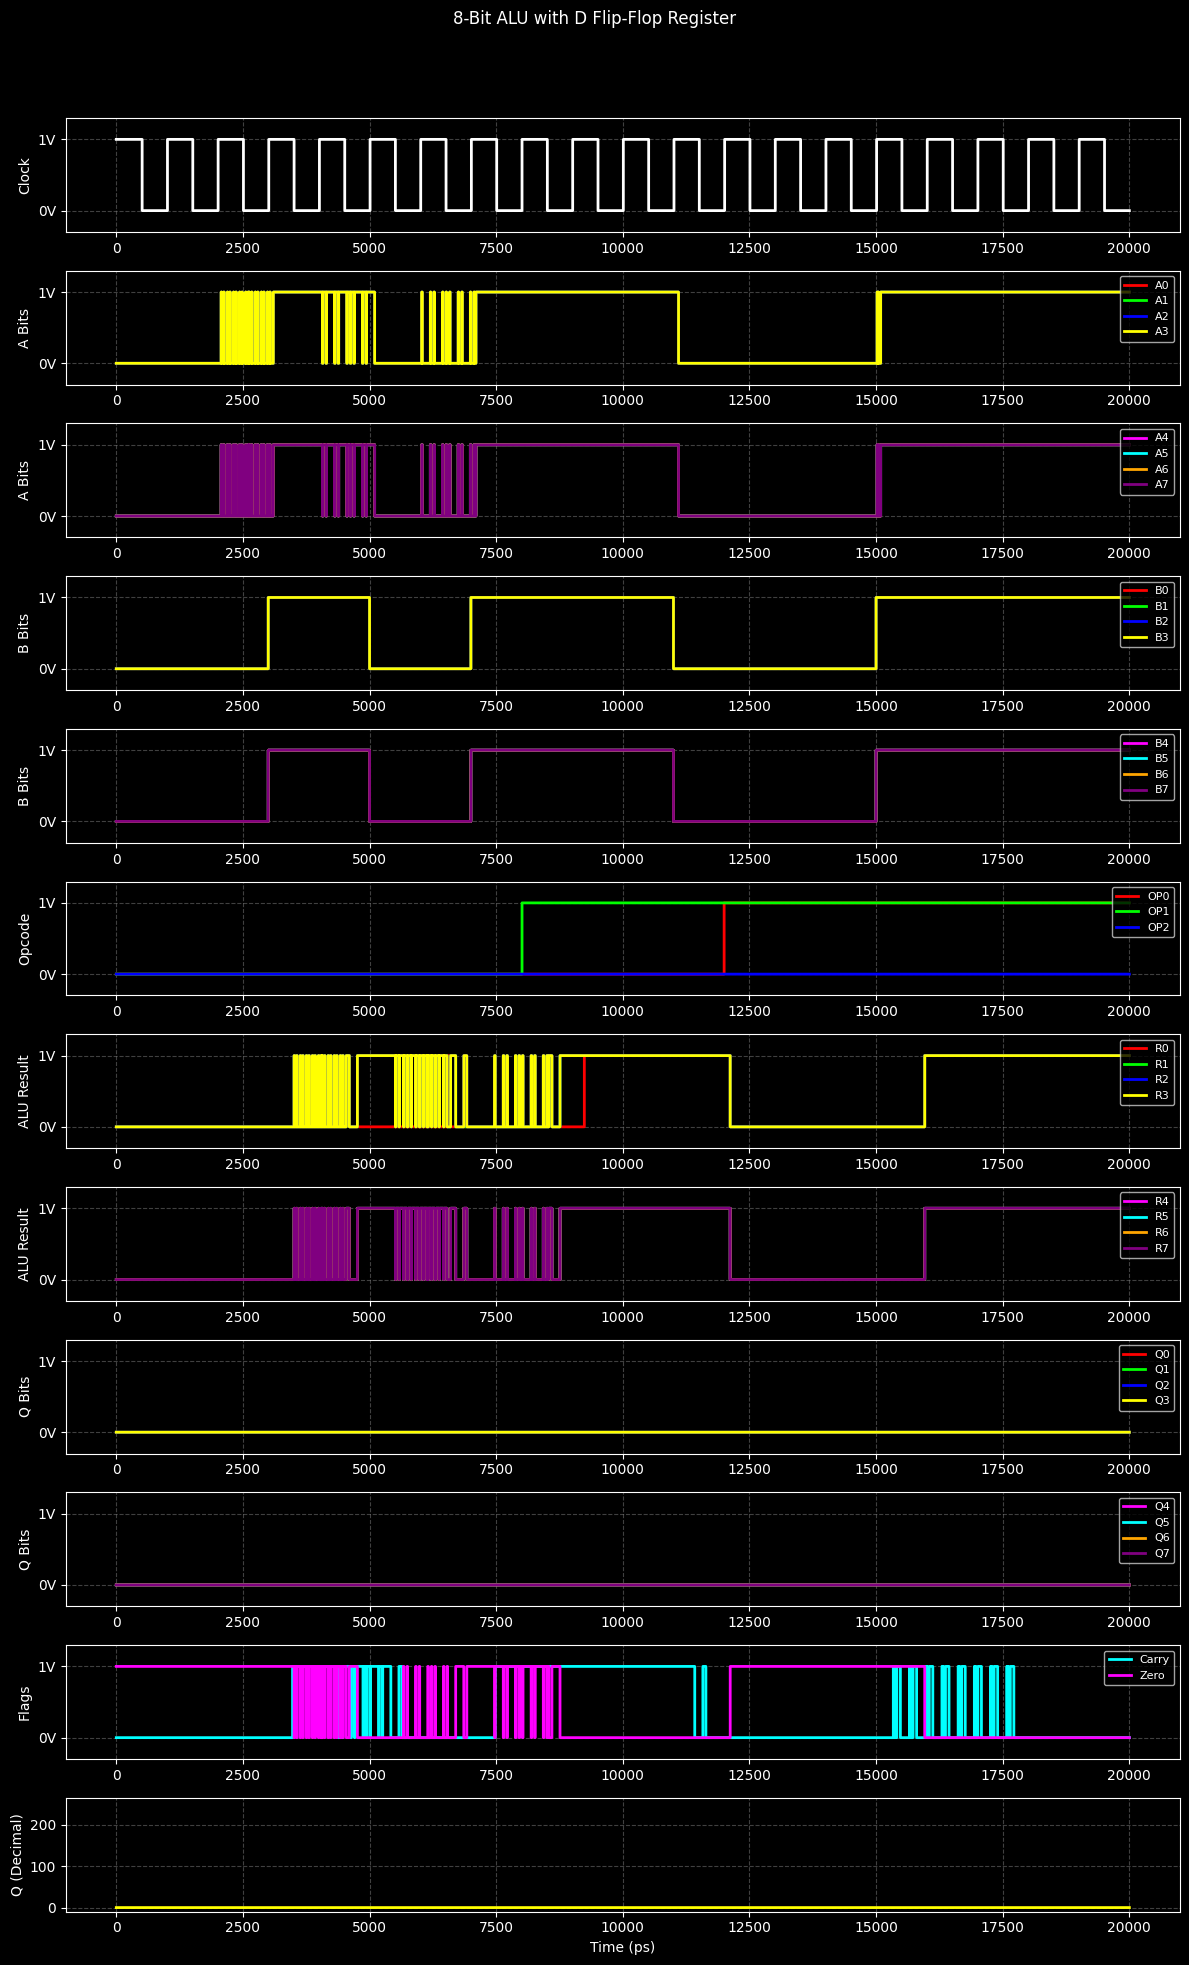

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from scipy.interpolate import interp1d

# Parameters
THRESHOLD = 0.5
DELAY_NOT = 50e-12  # NOT gate delay (50 ps)
DELAY_AND_OR = 100e-12  # AND/OR gate delay (100 ps)
DELAY_NOR = 150e-12  # NOR gate delay (150 ps)
DELAY_XOR = 150e-12  # XOR gate delay (150 ps)
STEP_SIZE = 10e-12  # Time step (10 ps)
CLOCK_PERIOD = 1000e-12  # Clock period (1000 ps, 1 MHz)

# Discrete gate functions
def not_gate(a, delay_queue, time):
    result = 1 if a < THRESHOLD else 0
    delay_queue.append((time + DELAY_NOT, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def and_gate(a, b, delay_queue, time):
    result = 1 if a >= THRESHOLD and b >= THRESHOLD else 0
    delay_queue.append((time + DELAY_AND_OR, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def or_gate(a, b, delay_queue, time):
    result = 1 if a >= THRESHOLD or b >= THRESHOLD else 0
    delay_queue.append((time + DELAY_AND_OR, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def xor_gate(a, b, delay_queue, time):
    result = 1 if (a >= THRESHOLD) != (b >= THRESHOLD) else 0
    delay_queue.append((time + DELAY_XOR, result))
    while delay_queue and delay_queue[0][0] <= time:
        return delay_queue.popleft()[1]
    return delay_queue[0][1] if delay_queue else result

def nor_gate(a, b, delay_queue, time):
    result = not_gate(or_gate(a, b, delay_queue['or'], time), 
                     delay_queue['not'], time)
    delay_queue['nor'].append((time + DELAY_NOR, result))
    while delay_queue['nor'] and delay_queue['nor'][0][0] <= time:
        return delay_queue['nor'].popleft()[1]
    return delay_queue['nor'][0][1] if delay_queue['nor'] else result

# 1-bit ALU
def alu_1bit(a, b, cin, opcode, delay_queues, time):
    op0, op1, op2 = opcode[0], opcode[1], opcode[2]
    
    # Full Adder for ADD/SUB
    b_sub = xor_gate(b, op0, delay_queues['xor_b'], time)
    sum_xor1 = xor_gate(a, b_sub, delay_queues['xor1'], time)
    result_add = xor_gate(sum_xor1, cin, delay_queues['xor2'], time)
    carry1 = and_gate(a, b_sub, delay_queues['and1'], time)
    carry2 = and_gate(sum_xor1, cin, delay_queues['and2'], time)
    cout = or_gate(carry1, carry2, delay_queues['or_carry'], time)
    
    result_sub = result_add
    result_and = and_gate(a, b, delay_queues['and_logic'], time)
    result_or = or_gate(a, b, delay_queues['or_logic'], time)
    result_xor = xor_gate(a, b, delay_queues['xor_logic'], time)
    result_shl = b if op0 == 0 else cin
    result_shr = b if op0 == 0 else cin
    
    # Multiplexer to select operation
    sel_add = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], time), 
                               not_gate(op1, delay_queues['mux_not1'], time), 
                               delay_queues['mux_and1'], time), 
                      not_gate(op0, delay_queues['mux_not0'], time), 
                      delay_queues['mux_and_add'], time)
    sel_sub = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], time), 
                               not_gate(op1, delay_queues['mux_not1'], time), 
                               delay_queues['mux_and1'], time), 
                      op0, delay_queues['mux_and_sub'], time)
    sel_and = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], time), 
                               op1, delay_queues['mux_and2'], time), 
                      not_gate(op0, delay_queues['mux_not0'], time), 
                      delay_queues['mux_and_and'], time)
    sel_or = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], time), 
                              op1, delay_queues['mux_and2'], time), 
                     op0, delay_queues['mux_and_or'], time)
    sel_xor = and_gate(and_gate(op2, not_gate(op1, delay_queues['mux_not1'], time), 
                               delay_queues['mux_and3'], time), 
                      not_gate(op0, delay_queues['mux_not0'], time), 
                      delay_queues['mux_and_xor'], time)
    sel_shl = and_gate(and_gate(op2, not_gate(op1, delay_queues['mux_not1'], time), 
                               delay_queues['mux_and3'], time), 
                      op0, delay_queues['mux_and_shl'], time)
    sel_shr = and_gate(and_gate(op2, op1, delay_queues['mux_and4'], time), 
                      not_gate(op0, delay_queues['mux_not0'], time), 
                      delay_queues['mux_and_shr'], time)
    
    result = or_gate(or_gate(or_gate(or_gate(or_gate(or_gate(
        and_gate(result_add, sel_add, delay_queues['mux_result1'], time),
        and_gate(result_sub, sel_sub, delay_queues['mux_result2'], time),
        delay_queues['mux_or1'], time),
        and_gate(result_and, sel_and, delay_queues['mux_result3'], time),
        delay_queues['mux_or2'], time),
        and_gate(result_or, sel_or, delay_queues['mux_result4'], time),
        delay_queues['mux_or3'], time),
        and_gate(result_xor, sel_xor, delay_queues['mux_result5'], time),
        delay_queues['mux_or4'], time),
        and_gate(result_shl, sel_shl, delay_queues['mux_result6'], time),
        delay_queues['mux_or5'], time),
        and_gate(result_shr, sel_shr, delay_queues['mux_result7'], time),
        delay_queues['mux_or6'], time)
    
    return result, cout

# 8-bit ALU
def alu_8bit(A, B, opcode, delay_queues, time):
    result = []
    cout = 0
    for i in range(8):
        res, cout = alu_1bit(A[i], B[i], cout, opcode, delay_queues[i], time)
        result.append(res)
    zero = 0 if any(res >= THRESHOLD for res in result) else 1
    return result, cout, zero

# Digital SR Latch
def sr_latch_update(S, R, Q, Q_bar, delay_queues, time):
    if S >= THRESHOLD and R >= THRESHOLD:
        return Q, Q_bar
    elif S >= THRESHOLD:
        next_Q, next_Q_bar = 1, 0
    elif R >= THRESHOLD:
        next_Q, next_Q_bar = 0, 1
    else:
        next_Q, next_Q_bar = Q, Q_bar

    delay_queues['Q'].append((time + DELAY_NOR, next_Q))
    delay_queues['Q_bar'].append((time + DELAY_NOR, next_Q_bar))
    
    delayed_Q = next_Q
    delayed_Q_bar = next_Q_bar
    while delay_queues['Q'] and delay_queues['Q'][0][0] <= time:
        delayed_Q = delay_queues['Q'].popleft()[1]
    while delay_queues['Q_bar'] and delay_queues['Q_bar'][0][0] <= time:
        delayed_Q_bar = delay_queues['Q_bar'].popleft()[1]
    
    return delayed_Q, delayed_Q_bar

# 8-bit D Flip-Flop
def d_flip_flop_8bit_update(D_bits, clock, states, delay_queues, time):
    Q_bits = []
    Q_bar_bits = []
    for i in range(8):
        Qm = states[i].get('Qm', 0)
        Qm_bar = states[i].get('Qm_bar', 1)
        Q = states[i].get('Q', 0)
        Q_bar = states[i].get('Q_bar', 1)
        prev_clock = states[i].get('prev_clock', 0)

        rising_edge = clock >= THRESHOLD and prev_clock < THRESHOLD

        if rising_edge:
            Sm = and_gate(D_bits[i], 1, delay_queues[i]['master']['and1'], time)
            Rm = and_gate(not_gate(D_bits[i], delay_queues[i]['master']['not'], time), 
                          1, delay_queues[i]['master']['and2'], time)
            Qm, Qm_bar = sr_latch_update(Sm, Rm, Qm, Qm_bar, delay_queues[i]['master']['latch'], time)

            Ss = and_gate(Qm, 1, delay_queues[i]['slave']['and1'], time)
            Rs = and_gate(not_gate(Qm, delay_queues[i]['slave']['not'], time), 
                          1, delay_queues[i]['slave']['and2'], time)
            Q, Q_bar = sr_latch_update(Ss, Rs, Q, Q_bar, delay_queues[i]['slave']['latch'], time)

        states[i]['Qm'] = Qm
        states[i]['Qm_bar'] = Qm_bar
        states[i]['Q'] = Q
        states[i]['Q_bar'] = Q_bar
        states[i]['prev_clock'] = clock
        Q_bits.append(Q)
        Q_bar_bits.append(Q_bar)
    
    return Q_bits, Q_bar_bits, states

# Simulate 8-bit ALU with D Flip-Flop
def simulate_alu_8bit(A_inputs, B_inputs, opcode_inputs, total_time=20000e-12, noise_level=0.05):
    time_steps = np.arange(0, total_time, STEP_SIZE)
    states = [{'Qm': 0, 'Qm_bar': 1, 'Q': 0, 'Q_bar': 1, 'prev_clock': 0} for _ in range(8)]
    
    # Initialize delay queues
    max_delay = int(round(max(DELAY_NOT, DELAY_AND_OR, DELAY_NOR, DELAY_XOR) / STEP_SIZE)) + 1
    alu_delay_queues = [{
        'xor_b': deque([(0, 0)] * max_delay),
        'xor1': deque([(0, 0)] * max_delay),
        'xor2': deque([(0, 0)] * max_delay),
        'and1': deque([(0, 0)] * max_delay),
        'and2': deque([(0, 0)] * max_delay),
        'or_carry': deque([(0, 0)] * max_delay),
        'and_logic': deque([(0, 0)] * max_delay),
        'or_logic': deque([(0, 0)] * max_delay),
        'xor_logic': deque([(0, 0)] * max_delay),
        'mux_not0': deque([(0, 0)] * max_delay),
        'mux_not1': deque([(0, 0)] * max_delay),
        'mux_not2': deque([(0, 0)] * max_delay),
        'mux_and1': deque([(0, 0)] * max_delay),
        'mux_and2': deque([(0, 0)] * max_delay),
        'mux_and3': deque([(0, 0)] * max_delay),
        'mux_and4': deque([(0, 0)] * max_delay),
        'mux_and_add': deque([(0, 0)] * max_delay),
        'mux_and_sub': deque([(0, 0)] * max_delay),
        'mux_and_and': deque([(0, 0)] * max_delay),
        'mux_and_or': deque([(0, 0)] * max_delay),
        'mux_and_xor': deque([(0, 0)] * max_delay),
        'mux_and_shl': deque([(0, 0)] * max_delay),
        'mux_and_shr': deque([(0, 0)] * max_delay),
        'mux_result1': deque([(0, 0)] * max_delay),
        'mux_result2': deque([(0, 0)] * max_delay),
        'mux_result3': deque([(0, 0)] * max_delay),
        'mux_result4': deque([(0, 0)] * max_delay),
        'mux_result5': deque([(0, 0)] * max_delay),
        'mux_result6': deque([(0, 0)] * max_delay),
        'mux_result7': deque([(0, 0)] * max_delay),
        'mux_or1': deque([(0, 0)] * max_delay),
        'mux_or2': deque([(0, 0)] * max_delay),
        'mux_or3': deque([(0, 0)] * max_delay),
        'mux_or4': deque([(0, 0)] * max_delay),
        'mux_or5': deque([(0, 0)] * max_delay),
        'mux_or6': deque([(0, 0)] * max_delay)
    } for _ in range(8)]
    
    dff_delay_queues = [{
        'D': deque([(0, 0)] * max_delay),
        'master': {
            'and1': deque([(0, 0)] * max_delay),
            'and2': deque([(0, 0)] * max_delay),
            'not': deque([(0, 0)] * max_delay),
            'or': deque([(0, 0)] * max_delay),
            'nor': deque([(0, 0)] * max_delay),
            'latch': {'Q': deque([(0, 0)] * max_delay), 'Q_bar': deque([(0, 1)] * max_delay)}
        },
        'slave': {
            'and1': deque([(0, 0)] * max_delay),
            'and2': deque([(0, 0)] * max_delay),
            'not': deque([(0, 0)] * max_delay),
            'or': deque([(0, 0)] * max_delay),
            'nor': deque([(0, 0)] * max_delay),
            'latch': {'Q': deque([(0, 0)] * max_delay), 'Q_bar': deque([(0, 1)] * max_delay)}
        }
    } for _ in range(8)]
    
    # Interpolate inputs
    A_interps = [interp1d(*zip(*bit_inputs), kind='previous', fill_value=bit_inputs[-1][1], bounds_error=False) 
                 for bit_inputs in A_inputs]
    B_interps = [interp1d(*zip(*bit_inputs), kind='previous', fill_value=bit_inputs[-1][1], bounds_error=False) 
                 for bit_inputs in B_inputs]
    opcode_interps = [interp1d(*zip(*op_inputs), kind='previous', fill_value=op_inputs[-1][1], bounds_error=False) 
                      for op_inputs in opcode_inputs]
    
    # Initialize output arrays
    A_values = [[] for _ in range(8)]
    B_values = [[] for _ in range(8)]
    opcode_values = [[] for _ in range(3)]
    alu_result_values = [[] for _ in range(8)]
    Q_values = [[] for _ in range(8)]
    clock_values = []
    carry_values = []
    zero_values = []
    
    for t in time_steps:
        clock = 1 if (t % CLOCK_PERIOD) < (CLOCK_PERIOD / 2) else 0
        clock = np.clip(clock + np.random.normal(0, noise_level), 0, 1)
        clock = 1 if clock >= THRESHOLD else 0
        
        A_bits = [np.clip(interp(t) + np.random.normal(0, noise_level), 0, 1) for interp in A_interps]
        A_bits = [1 if a >= THRESHOLD else 0 for a in A_bits]
        B_bits = [np.clip(interp(t) + np.random.normal(0, noise_level), 0, 1) for interp in B_interps]
        B_bits = [1 if b >= THRESHOLD else 0 for b in B_bits]
        opcode = [np.clip(interp(t) + np.random.normal(0, noise_level), 0, 1) for interp in opcode_interps]
        opcode = [1 if op >= THRESHOLD else 0 for op in opcode]
        
        # Update delay queues for inputs
        for i in range(8):
            dff_delay_queues[i]['D'].append((t + DELAY_AND_OR, A_bits[i]))
            while dff_delay_queues[i]['D'] and dff_delay_queues[i]['D'][0][0] <= t:
                A_bits[i] = dff_delay_queues[i]['D'].popleft()[1]
            dff_delay_queues[i]['D'].append((t + DELAY_AND_OR, B_bits[i]))
            while dff_delay_queues[i]['D'] and dff_delay_queues[i]['D'][0][0] <= t:
                B_bits[i] = dff_delay_queues[i]['D'].popleft()[1]
        
        alu_result, carry, zero = alu_8bit(A_bits, B_bits, opcode, alu_delay_queues, t)
        Q_bits, Q_bar_bits, states = d_flip_flop_8bit_update(alu_result, clock, states, dff_delay_queues, t)
        
        for i in range(8):
            A_values[i].append(A_bits[i])
            B_values[i].append(B_bits[i])
            alu_result_values[i].append(alu_result[i])
            Q_values[i].append(Q_bits[i])
        for i in range(3):
            opcode_values[i].append(opcode[i])
        clock_values.append(clock)
        carry_values.append(carry)
        zero_values.append(zero)
    
    return time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, carry_values, zero_values

# Visualize
def plot_oscilloscope(time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, 
                     carry_values, zero_values):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 20))
    
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#800080']
    
    ax_clock = fig.add_subplot(12, 1, 1)
    ax_clock.step(time_steps * 1e12, clock_values, where='post', color='white', linewidth=2)
    ax_clock.set_ylabel('Clock', color='white', fontsize=10)
    ax_clock.set_ylim(-0.3, 1.3)
    ax_clock.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_clock.set_yticks([0, 1])
    ax_clock.set_yticklabels(['0V', '1V'], color='white')
    
    axes_A = [fig.add_subplot(12, 1, i+2) for i in range(2)]
    axes_B = [fig.add_subplot(12, 1, i+4) for i in range(2)]
    for i in range(8):
        ax_A = axes_A[i // 4]
        ax_B = axes_B[i // 4]
        ax_A.step(time_steps * 1e12, A_values[i], where='post', color=colors[i], linewidth=2, label=f'A{i}')
        ax_B.step(time_steps * 1e12, B_values[i], where='post', color=colors[i], linewidth=2, label=f'B{i}')
    
    ax_opcode = fig.add_subplot(12, 1, 6)
    for i in range(3):
        ax_opcode.step(time_steps * 1e12, opcode_values[i], where='post', color=colors[i], linewidth=2, label=f'OP{i}')
    ax_opcode.set_ylabel('Opcode', color='white', fontsize=10)
    ax_opcode.set_ylim(-0.3, 1.3)
    ax_opcode.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_opcode.set_yticks([0, 1])
    ax_opcode.set_yticklabels(['0V', '1V'], color='white')
    ax_opcode.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    axes_result = [fig.add_subplot(12, 1, i+7) for i in range(2)]
    axes_Q = [fig.add_subplot(12, 1, i+9) for i in range(2)]
    for i in range(8):
        ax_result = axes_result[i // 4]
        ax_Q = axes_Q[i // 4]
        ax_result.step(time_steps * 1e12, alu_result_values[i], where='post', color=colors[i], linewidth=2, label=f'R{i}')
        ax_Q.step(time_steps * 1e12, Q_values[i], where='post', color=colors[i], linewidth=2, label=f'Q{i}')
    
    for ax in axes_A + axes_B + axes_result + axes_Q:
        ax.set_ylim(-0.3, 1.3)
        ax.grid(True, color='gray', linestyle='--', alpha=0.5)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0V', '1V'], color='white')
        ax.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    for ax in axes_A:
        ax.set_ylabel('A Bits', color='white', fontsize=10)
    for ax in axes_B:
        ax.set_ylabel('B Bits', color='white', fontsize=10)
    for ax in axes_result:
        ax.set_ylabel('ALU Result', color='white', fontsize=10)
    for ax in axes_Q:
        ax.set_ylabel('Q Bits', color='white', fontsize=10)
    
    ax_flags = fig.add_subplot(12, 1, 11)
    ax_flags.step(time_steps * 1e12, carry_values, where='post', color='cyan', linewidth=2, label='Carry')
    ax_flags.step(time_steps * 1e12, zero_values, where='post', color='magenta', linewidth=2, label='Zero')
    ax_flags.set_ylabel('Flags', color='white', fontsize=10)
    ax_flags.set_ylim(-0.3, 1.3)
    ax_flags.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_flags.set_yticks([0, 1])
    ax_flags.set_yticklabels(['0V', '1V'], color='white')
    ax_flags.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    Q_decimal = [sum(Q_values[i][j] * (2**i) for i in range(8)) for j in range(len(time_steps))]
    ax_decimal = fig.add_subplot(12, 1, 12)
    ax_decimal.step(time_steps * 1e12, Q_decimal, where='post', color='yellow', linewidth=2)
    transitions = np.where(np.diff(Q_decimal) != 0)[0] + 1
    for idx in transitions:
        ax_decimal.plot(time_steps[idx] * 1e12, Q_decimal[idx], 'ro', markersize=5)
    ax_decimal.set_ylabel('Q (Decimal)', color='white', fontsize=10)
    ax_decimal.set_xlabel('Time (ps)', color='white', fontsize=10)
    ax_decimal.set_ylim(-10, 265)
    ax_decimal.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_decimal.tick_params(axis='y', colors='white')
    
    fig.suptitle('8-Bit ALU with D Flip-Flop Register', color='white', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
if __name__ == "__main__":
    A_inputs = [
        [(0, 0), (2000e-12, 1), (4000e-12, 0), (6000e-12, 1), (10000e-12, 0), (14000e-12, 1)] for _ in range(8)
    ]
    B_inputs = [
        [(0, 0), (3000e-12, 1), (5000e-12, 0), (7000e-12, 1), (11000e-12, 0), (15000e-12, 1)] for _ in range(8)
    ]
    opcode_inputs = [
        [(0, 0), (4000e-12, 0), (8000e-12, 0), (12000e-12, 1)],  # op0: ADD->ADD->OR
        [(0, 0), (4000e-12, 0), (8000e-12, 1), (12000e-12, 1)],  # op1: ADD->ADD->OR
        [(0, 0), (4000e-12, 0), (8000e-12, 0), (12000e-12, 0)]   # op2: ADD->ADD->OR
    ]
    
    time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, carry_values, zero_values = simulate_alu_8bit(
        A_inputs, B_inputs, opcode_inputs, total_time=20000e-12, noise_level=0.05)
    plot_oscilloscope(time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, 
                      clock_values, carry_values, zero_values)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from scipy.interpolate import interp1d

# Parameters
THRESHOLD = 0.5
DELAY_NOT = 50e-12  # NOT gate delay (50 ps)
DELAY_AND_OR = 100e-12  # AND/OR gate delay (100 ps)
DELAY_NOR = 150e-12  # NOR gate delay (150 ps)
DELAY_XOR = 150e-12  # XOR gate delay (150 ps)
STEP_SIZE = 10e-12  # Time step (10 ps)
CLOCK_PERIOD = 1000e-12  # Clock period (1000 ps, 1 MHz)

# Optimized gate delay application
def apply_delay(result, delay, queue, time):
    queue.append((time + delay, result))
    while queue and queue[0][0] <= time:
        queue.popleft()
    return queue[0][1] if queue else result

# Discrete gate functions
def not_gate(a, delay_queue, time):
    result = 1 if a < THRESHOLD else 0
    return apply_delay(result, DELAY_NOT, delay_queue, time)

def and_gate(a, b, delay_queue, time):
    result = 1 if a >= THRESHOLD and b >= THRESHOLD else 0
    return apply_delay(result, DELAY_AND_OR, delay_queue, time)

def or_gate(a, b, delay_queue, time):
    result = 1 if a >= THRESHOLD or b >= THRESHOLD else 0
    return apply_delay(result, DELAY_AND_OR, delay_queue, time)

def xor_gate(a, b, delay_queue, time):
    result = 1 if (a >= THRESHOLD) != (b >= THRESHOLD) else 0
    return apply_delay(result, DELAY_XOR, delay_queue, time)

def nor_gate(a, b, delay_queue, time):
    result = not_gate(or_gate(a, b, delay_queue['or'], time), delay_queue['not'], time)
    return apply_delay(result, DELAY_NOR, delay_queue['nor'], time)

# 1-bit ALU
def alu_1bit(a, b, cin, opcode, delay_queues, time):
    op0, op1, op2 = opcode[0], opcode[1], opcode[2]
    
    b_sub = xor_gate(b, op0, delay_queues['xor_b'], time)
    sum_xor1 = xor_gate(a, b_sub, delay_queues['xor1'], time)
    result_add = xor_gate(sum_xor1, cin, delay_queues['xor2'], time)
    carry1 = and_gate(a, b_sub, delay_queues['and1'], time)
    carry2 = and_gate(sum_xor1, cin, delay_queues['and2'], time)
    cout = or_gate(carry1, carry2, delay_queues['or_carry'], time)
    
    result_sub = result_add
    result_and = and_gate(a, b, delay_queues['and_logic'], time)
    result_or = or_gate(a, b, delay_queues['or_logic'], time)
    result_xor = xor_gate(a, b, delay_queues['xor_logic'], time)
    result_shl = b if op0 == 0 else cin
    result_shr = b if op0 == 0 else cin
    
    sel_add = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], time), 
                               not_gate(op1, delay_queues['mux_not1'], time), 
                               delay_queues['mux_and1'], time), 
                      not_gate(op0, delay_queues['mux_not0'], time), 
                      delay_queues['mux_and_add'], time)
    sel_sub = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], time), 
                               not_gate(op1, delay_queues['mux_not1'], time), 
                               delay_queues['mux_and1'], time), 
                      op0, delay_queues['mux_and_sub'], time)
    sel_and = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], time), 
                               op1, delay_queues['mux_and2'], time), 
                      not_gate(op0, delay_queues['mux_not0'], time), 
                      delay_queues['mux_and_and'], time)
    sel_or = and_gate(and_gate(not_gate(op2, delay_queues['mux_not2'], time), 
                              op1, delay_queues['mux_and2'], time), 
                     op0, delay_queues['mux_and_or'], time)
    sel_xor = and_gate(and_gate(op2, not_gate(op1, delay_queues['mux_not1'], time), 
                               delay_queues['mux_and3'], time), 
                      not_gate(op0, delay_queues['mux_not0'], time), 
                      delay_queues['mux_and_xor'], time)
    sel_shl = and_gate(and_gate(op2, not_gate(op1, delay_queues['mux_not1'], time), 
                               delay_queues['mux_and3'], time), 
                      op0, delay_queues['mux_and_shl'], time)
    sel_shr = and_gate(and_gate(op2, op1, delay_queues['mux_and4'], time), 
                      not_gate(op0, delay_queues['mux_not0'], time), 
                      delay_queues['mux_and_shr'], time)
    
    result = or_gate(or_gate(or_gate(or_gate(or_gate(or_gate(
        and_gate(result_add, sel_add, delay_queues['mux_result1'], time),
        and_gate(result_sub, sel_sub, delay_queues['mux_result2'], time),
        delay_queues['mux_or1'], time),
        and_gate(result_and, sel_and, delay_queues['mux_result3'], time),
        delay_queues['mux_or2'], time),
        and_gate(result_or, sel_or, delay_queues['mux_result4'], time),
        delay_queues['mux_or3'], time),
        and_gate(result_xor, sel_xor, delay_queues['mux_result5'], time),
        delay_queues['mux_or4'], time),
        and_gate(result_shl, sel_shl, delay_queues['mux_result6'], time),
        delay_queues['mux_or5'], time),
        and_gate(result_shr, sel_shr, delay_queues['mux_result7'], time),
        delay_queues['mux_or6'], time)
    
    return result, cout

# 8-bit ALU
def alu_8bit(A, B, opcode, delay_queues, time):
    result = []
    cout = 0
    for i in range(8):
        res, cout = alu_1bit(A[i], B[i], cout, opcode, delay_queues[i], time)
        result.append(res)
    zero = 0 if any(res >= THRESHOLD for res in result) else 1
    return result, cout, zero

# Digital SR Latch
def sr_latch_update(S, R, Q, Q_bar, delay_queue, time):
    if S >= THRESHOLD and R >= THRESHOLD:
        return Q, Q_bar
    elif S >= THRESHOLD:
        next_Q, next_Q_bar = 1, 0
    elif R >= THRESHOLD:
        next_Q, next_Q_bar = 0, 1
    else:
        next_Q, next_Q_bar = Q, Q_bar

    delay_queue['Q'].append((time + DELAY_NOR, next_Q))
    delay_queue['Q_bar'].append((time + DELAY_NOR, next_Q_bar))
    
    while delay_queue['Q'] and delay_queue['Q'][0][0] <= time:
        delay_queue['Q'].popleft()
    while delay_queue['Q_bar'] and delay_queue['Q_bar'][0][0] <= time:
        delay_queue['Q_bar'].popleft()
    
    delayed_Q = delay_queue['Q'][0][1] if delay_queue['Q'] else next_Q
    delayed_Q_bar = delay_queue['Q_bar'][0][1] if delay_queue['Q_bar'] else next_Q_bar
    return delayed_Q, delayed_Q_bar

# 8-bit D Flip-Flop
def d_flip_flop_8bit_update(D_bits, clock, states, delay_queues, time):
    Q_bits = []
    Q_bar_bits = []
    for i in range(8):
        Qm = states[i].get('Qm', 0)
        Qm_bar = states[i].get('Qm_bar', 1)
        Q = states[i].get('Q', 0)
        Q_bar = states[i].get('Q_bar', 1)
        prev_clock = states[i].get('prev_clock', 0)

        rising_edge = clock >= THRESHOLD and prev_clock < THRESHOLD

        if rising_edge:
            Sm = and_gate(D_bits[i], 1, delay_queues[i]['master']['and1'], time)
            Rm = and_gate(not_gate(D_bits[i], delay_queues[i]['master']['not'], time), 
                          1, delay_queues[i]['master']['and2'], time)
            Qm, Qm_bar = sr_latch_update(Sm, Rm, Qm, Qm_bar, delay_queues[i]['master']['latch'], time)

            Ss = and_gate(Qm, 1, delay_queues[i]['slave']['and1'], time)
            Rs = and_gate(not_gate(Qm, delay_queues[i]['slave']['not'], time), 
                          1, delay_queues[i]['slave']['and2'], time)
            Q, Q_bar = sr_latch_update(Ss, Rs, Q, Q_bar, delay_queues[i]['slave']['latch'], time)

        states[i]['Qm'] = Qm
        states[i]['Qm_bar'] = Qm_bar
        states[i]['Q'] = Q
        states[i]['Q_bar'] = Q_bar
        states[i]['prev_clock'] = clock
        Q_bits.append(Q)
        Q_bar_bits.append(Q_bar)
    
    return Q_bits, Q_bar_bits, states

# Simulate 8-bit ALU with D Flip-Flop
def simulate_alu_8bit(A_inputs, B_inputs, opcode_inputs, total_time=20000e-12, noise_level=0.05):
    time_steps = np.arange(0, total_time, STEP_SIZE)
    states = [{'Qm': 0, 'Qm_bar': 1, 'Q': 0, 'Q_bar': 1, 'prev_clock': 0} for _ in range(8)]
    
    max_delay = int(round(max(DELAY_NOT, DELAY_AND_OR, DELAY_NOR, DELAY_XOR) / STEP_SIZE)) + 1
    alu_delay_queues = [{
        'xor_b': deque([(0, 0)] * max_delay),
        'xor1': deque([(0, 0)] * max_delay),
        'xor2': deque([(0, 0)] * max_delay),
        'and1': deque([(0, 0)] * max_delay),
        'and2': deque([(0, 0)] * max_delay),
        'or_carry': deque([(0, 0)] * max_delay),
        'and_logic': deque([(0, 0)] * max_delay),
        'or_logic': deque([(0, 0)] * max_delay),
        'xor_logic': deque([(0, 0)] * max_delay),
        'mux_not0': deque([(0, 0)] * max_delay),
        'mux_not1': deque([(0, 0)] * max_delay),
        'mux_not2': deque([(0, 0)] * max_delay),
        'mux_and1': deque([(0, 0)] * max_delay),
        'mux_and2': deque([(0, 0)] * max_delay),
        'mux_and3': deque([(0, 0)] * max_delay),
        'mux_and4': deque([(0, 0)] * max_delay),
        'mux_and_add': deque([(0, 0)] * max_delay),
        'mux_and_sub': deque([(0, 0)] * max_delay),
        'mux_and_and': deque([(0, 0)] * max_delay),
        'mux_and_or': deque([(0, 0)] * max_delay),
        'mux_and_xor': deque([(0, 0)] * max_delay),
        'mux_and_shl': deque([(0, 0)] * max_delay),
        'mux_and_shr': deque([(0, 0)] * max_delay),
        'mux_result1': deque([(0, 0)] * max_delay),
        'mux_result2': deque([(0, 0)] * max_delay),
        'mux_result3': deque([(0, 0)] * max_delay),
        'mux_result4': deque([(0, 0)] * max_delay),
        'mux_result5': deque([(0, 0)] * max_delay),
        'mux_result6': deque([(0, 0)] * max_delay),
        'mux_result7': deque([(0, 0)] * max_delay),
        'mux_or1': deque([(0, 0)] * max_delay),
        'mux_or2': deque([(0, 0)] * max_delay),
        'mux_or3': deque([(0, 0)] * max_delay),
        'mux_or4': deque([(0, 0)] * max_delay),
        'mux_or5': deque([(0, 0)] * max_delay),
        'mux_or6': deque([(0, 0)] * max_delay)
    } for _ in range(8)]
    
    dff_delay_queues = [{
        'D': deque([(0, 0)] * max_delay),
        'master': {
            'and1': deque([(0, 0)] * max_delay),
            'and2': deque([(0, 0)] * max_delay),
            'not': deque([(0, 0)] * max_delay),
            'or': deque([(0, 0)] * max_delay),
            'nor': deque([(0, 0)] * max_delay),
            'latch': {'Q': deque([(0, 0)] * max_delay), 'Q_bar': deque([(0, 1)] * max_delay)}
        },
        'slave': {
            'and1': deque([(0, 0)] * max_delay),
            'and2': deque([(0, 0)] * max_delay),
            'not': deque([(0, 0)] * max_delay),
            'or': deque([(0, 0)] * max_delay),
            'nor': deque([(0, 0)] * max_delay),
            'latch': {'Q': deque([(0, 0)] * max_delay), 'Q_bar': deque([(0, 1)] * max_delay)}
        }
    } for _ in range(8)]
    
    A_interps = [interp1d(*zip(*bit_inputs), kind='previous', fill_value=bit_inputs[-1][1], bounds_error=False) 
                 for bit_inputs in A_inputs]
    B_interps = [interp1d(*zip(*bit_inputs), kind='previous', fill_value=bit_inputs[-1][1], bounds_error=False) 
                 for bit_inputs in B_inputs]
    opcode_interps = [interp1d(*zip(*op_inputs), kind='previous', fill_value=op_inputs[-1][1], bounds_error=False) 
                      for op_inputs in opcode_inputs]
    
    A_values = [[] for _ in range(8)]
    B_values = [[] for _ in range(8)]
    opcode_values = [[] for _ in range(3)]
    alu_result_values = [[] for _ in range(8)]
    Q_values = [[] for _ in range(8)]
    clock_values = []
    carry_values = []
    zero_values = []
    
    for t in time_steps:
        clock = 1 if (t % CLOCK_PERIOD) < (CLOCK_PERIOD / 2) else 0
        clock = np.clip(clock + np.random.normal(0, noise_level), 0, 1)
        clock = 1 if clock >= THRESHOLD else 0
        
        A_bits = [np.clip(interp(t) + np.random.normal(0, noise_level), 0, 1) for interp in A_interps]
        A_bits = [1 if a >= THRESHOLD else 0 for a in A_bits]
        B_bits = [np.clip(interp(t) + np.random.normal(0, noise_level), 0, 1) for interp in B_interps]
        B_bits = [1 if b >= THRESHOLD else 0 for b in B_bits]
        opcode = [np.clip(interp(t) + np.random.normal(0, noise_level), 0, 1) for interp in opcode_interps]
        opcode = [1 if op >= THRESHOLD else 0 for op in opcode]
        
        for i in range(8):
            A_bits[i] = apply_delay(A_bits[i], DELAY_AND_OR, dff_delay_queues[i]['D'], t)
            B_bits[i] = apply_delay(B_bits[i], DELAY_AND_OR, dff_delay_queues[i]['D'], t)
        
        alu_result, carry, zero = alu_8bit(A_bits, B_bits, opcode, alu_delay_queues, t)
        Q_bits, Q_bar_bits, states = d_flip_flop_8bit_update(alu_result, clock, states, dff_delay_queues, t)
        
        for i in range(8):
            A_values[i].append(A_bits[i])
            B_values[i].append(B_bits[i])
            alu_result_values[i].append(alu_result[i])
            Q_values[i].append(Q_bits[i])
        for i in range(3):
            opcode_values[i].append(opcode[i])
        clock_values.append(clock)
        carry_values.append(carry)
        zero_values.append(zero)
    
    return time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, carry_values, zero_values

# Visualize
def plot_oscilloscope(time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, 
                     carry_values, zero_values):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 20))
    
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#800080']
    
    ax_clock = fig.add_subplot(12, 1, 1)
    ax_clock.step(time_steps * 1e12, clock_values, where='post', color='white', linewidth=2)
    ax_clock.set_ylabel('Clock', color='white', fontsize=10)
    ax_clock.set_ylim(-0.3, 1.3)
    ax_clock.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_clock.set_yticks([0, 1])
    ax_clock.set_yticklabels(['0V', '1V'], color='white')
    
    axes_A = [fig.add_subplot(12, 1, i+2) for i in range(2)]
    axes_B = [fig.add_subplot(12, 1, i+4) for i in range(2)]
    for i in range(8):
        ax_A = axes_A[i // 4]
        ax_B = axes_B[i // 4]
        ax_A.step(time_steps * 1e12, A_values[i], where='post', color=colors[i], linewidth=2, label=f'A{i}')
        ax_B.step(time_steps * 1e12, B_values[i], where='post', color=colors[i], linewidth=2, label=f'B{i}')
    
    ax_opcode = fig.add_subplot(12, 1, 6)
    for i in range(3):
        ax_opcode.step(time_steps * 1e12, opcode_values[i], where='post', color=colors[i], linewidth=2, label=f'OP{i}')
    ax_opcode.set_ylabel('Opcode', color='white', fontsize=10)
    ax_opcode.set_ylim(-0.3, 1.3)
    ax_opcode.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_opcode.set_yticks([0, 1])
    ax_opcode.set_yticklabels(['0V', '1V'], color='white')
    ax_opcode.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    axes_result = [fig.add_subplot(12, 1, i+7) for i in range(2)]
    axes_Q = [fig.add_subplot(12, 1, i+9) for i in range(2)]
    for i in range(8):
        ax_result = axes_result[i // 4]
        ax_Q = axes_Q[i // 4]
        ax_result.step(time_steps * 1e12, alu_result_values[i], where='post', color=colors[i], linewidth=2, label=f'R{i}')
        ax_Q.step(time_steps * 1e12, Q_values[i], where='post', color=colors[i], linewidth=2, label=f'Q{i}')
    
    for ax in axes_A + axes_B + axes_result + axes_Q:
        ax.set_ylim(-0.3, 1.3)
        ax.grid(True, color='gray', linestyle='--', alpha=0.5)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0V', '1V'], color='white')
        ax.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    for ax in axes_A:
        ax.set_ylabel('A Bits', color='white', fontsize=10)
    for ax in axes_B:
        ax.set_ylabel('B Bits', color='white', fontsize=10)
    for ax in axes_result:
        ax.set_ylabel('ALU Result', color='white', fontsize=10)
    for ax in axes_Q:
        ax.set_ylabel('Q Bits', color='white', fontsize=10)
    
    ax_flags = fig.add_subplot(12, 1, 11)
    ax_flags.step(time_steps * 1e12, carry_values, where='post', color='cyan', linewidth=2, label='Carry')
    ax_flags.step(time_steps * 1e12, zero_values, where='post', color='magenta', linewidth=2, label='Zero')
    ax_flags.set_ylabel('Flags', color='white', fontsize=10)
    ax_flags.set_ylim(-0.3, 1.3)
    ax_flags.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_flags.set_yticks([0, 1])
    ax_flags.set_yticklabels(['0V', '1V'], color='white')
    ax_flags.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    Q_decimal = [sum(Q_values[i][j] * (2**i) for i in range(8)) for j in range(len(time_steps))]
    ax_decimal = fig.add_subplot(12, 1, 12)
    ax_decimal.step(time_steps * 1e12, Q_decimal, where='post', color='yellow', linewidth=2)
    transitions = np.where(np.diff(Q_decimal) != 0)[0] + 1
    for idx in transitions:
        ax_decimal.plot(time_steps[idx] * 1e12, Q_decimal[idx], 'ro', markersize=5)
    ax_decimal.set_ylabel('Q (Decimal)', color='white', fontsize=10)
    ax_decimal.set_xlabel('Time (ps)', color='white', fontsize=10)
    ax_decimal.set_ylim(-10, 265)
    ax_decimal.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_decimal.tick_params(axis='y', colors='white')
    
    fig.suptitle('8-Bit ALU with Optimized Delay Modeling', color='white', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
if __name__ == "__main__":
    A_inputs = [
        [(0, 0), (2000e-12, 1), (4000e-12, 0), (6000e-12, 1), (10000e-12, 0), (14000e-12, 1)] for _ in range(8)
    ]
    B_inputs = [
        [(0, 0), (3000e-12, 1), (5000e-12, 0), (7000e-12, 1), (11000e-12, 0), (15000e-12, 1)] for _ in range(8)
    ]
    opcode_inputs = [
        [(0, 0), (4000e-12, 0), (8000e-12, 0), (12000e-12, 1)],  # op0: ADD->ADD->OR
        [(0, 0), (4000e-12, 0), (8000e-12, 1), (12000e-12, 1)],  # op1: ADD->ADD->OR
        [(0, 0), (4000e-12, 0), (8000e-12, 0), (12000e-12, 0)]   # op2: ADD->ADD->OR
    ]
    
    time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, carry_values, zero_values = simulate_alu_8bit(
        A_inputs, B_inputs, opcode_inputs, total_time=20000e-12, noise_level=0.05)
    plot_oscilloscope(time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, 
                      clock_values, carry_values, zero_values)